# Natural language processing pipeline : use plot data to extract meaningfull insights

**Pipeline:**

1) Extract tags for each movie genres
2) Natural language text generation of new plots based on key tags
3) Sentiment analysis of plots

# Part I : Extract tags for each movie genres

This code aims to: 

- Clean the movies plots
- Extract the key tags for each genre
- We try 4 methodologies
- Vizualize main themes

In [3]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### Open data

In [4]:
df_movie = pd.read_csv('../Datasets/movies_cleaned_dataset.csv')
df_movie.head()

,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_genres,Main_genre,Main_language,Top_genres,Main_country,Main_continent,Plot_summary,...,averageRating,numVotes,Estimated_Budget,IMDb,Oscar_Wins,Nominations,Profit,Inflation_adjusted_profit,nconst,Director_name
0,Ghosts of Mars,14010832,98.0,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","['Thriller', 'Science Fiction', 'Horror', 'Adv...",English Language,Drama,United States of America,USA,"Set in the second half of the 22nd century, th...",...,4.9,56894.0,28000000,tt0228333,0,0,-13989168,-1.870336e+07,nm0000118,John Carpenter
1,White Of The Eye,0,110.0,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","['Thriller', 'Erotic thriller', 'Psychological...",English Language,Drama,United Kingdom,Europe,A series of murders of rich young women throug...,...,6.1,2894.0,0,tt0094320,0,0,0,0.000000e+00,nm0131910,Donald Cammell
2,A Woman in Flames,0,106.0,"{""/m/07s9rl0"": ""Drama""}",Drama,German Language,Other,Germany,Europe,"Eva, an upper class housewife, becomes frustra...",...,5.9,623.0,0,tt0083949,0,0,0,0.000000e+00,nm0885554,Robert van Ackeren
3,The Sorcerer's Apprentice,0,86.0,"{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","['Family Film', 'Fantasy', 'Adventure', 'World...",English Language,Family,South Africa,Africa,"Every hundred years, the evil Morgana returns...",...,NaN,NaN,0,NaN,0,0,0,0.000000e+00,NaN,Unknown
4,Little city,0,93.0,"{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","['Romantic comedy', 'Ensemble Film', 'Comedy-d...",English Language,Drama,United States of America,USA,"Adam, a San Francisco-based artist who works a...",...,5.8,1129.0,0,tt0119548,0,0,0,0.000000e+00,nm0070142,Roberto Benabib


In [3]:
df_movie.Top_genres.replace('Action/Adventure', 'Action_Adventure', inplace=True)

In [4]:
df_movie.Top_genres.unique()

array(['Drama', 'Other', 'Family', 'Fiction', 'Action_Adventure',
       'Horror'], dtype=object)

## First approach: extracting Stopwords

- We observe that extracting punctuation and stopwords, and identify the most common remaining words does not allow us to get truly meaning full list of words for each genre. 
- We ought to explore another methodology to extract meaningfull lexicas.

In [5]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Download NLTK stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Function to preprocess and tokenize text
def preprocess_text(text):
    """ 
    This function takes in a text and returns a list of tokens after removing stopwords
    """
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

# Function to identify words defining a genre
def identify_genre_words(df, genre, num_words=30):
    """
    This function takes in a dataframe and a genre and returns the most common words in the genre's movie plots. 
    """
    genre_df = df[df['Top_genres'] == genre]
    all_tokens = [token for plot in genre_df['Plot_summary'] for token in preprocess_text(plot)]
    word_counts = Counter(all_tokens)
    
    # Get the most common words
    common_words = [word for word, count in word_counts.most_common(num_words)]
    return common_words

# Example usage:
for genre in df_movie['Top_genres'].unique():
    genre_words = identify_genre_words(df_movie, genre, num_words=30)
    print(f"Words defining {genre}: {', '.join(genre_words)}")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoinedebouille/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/antoinedebouille/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Words defining Drama: one, father, back, two, tells, film, man, life, home, new, mother, family, later, time, love, police, house, finds, also, find, however, get, wife, goes, young, day, takes, go, away, son
Words defining Other: one, film, back, father, two, love, man, life, time, get, family, also, house, tom, home, however, tells, new, gets, mother, goes, takes, finds, find, story, young, later, away, go, day
Words defining Family: one, back, get, love, father, new, two, tells, family, home, film, time, however, go, find, also, mother, day, house, life, finds, gets, help, man, goes, friends, first, takes, later, school
Words defining Fiction: one, back, earth, two, time, find, however, ship, new, planet, also, world, film, alien, escape, finds, later, man, help, takes, home, killed, first, tells, group, get, life, city, space, begins
Words defining Action/Adventure: one, back, two, men, father, man, killed, film, also, tells, get, police, however, later, find, fight, time, new, tak

## Second approach: Extracting tags using SpaCy

### Named entity recognition
https://spacy.io/usage/linguistic-features

We use spacy pre-trained model to identify the tags for each movies. This library allows to identify entity types for each word and therefore to extract only thoses who are truly meaningfull. 

**The entity types are:**

- PERSON: People, including fictional.
- ORG: Organizations, e.g., companies, governments, institutions.
- GPE: Geopolitical entities, e.g., countries, cities, states.
- LOC: Locations, e.g., non-GPE locations, mountain ranges, bodies of water.
- EVENT: Named events, e.g., hurricanes, wars, sports events.
- DATE: Absolute or relative dates or periods.
- TIME: Times smaller than a day.
- MONEY: Monetary values, including unit.
- QUANTITY: Measurements, as of weight or distance.
- PERCENT: Percentage, including "%" symbol.
- CARDINAL: Numerals that do not fall under another type.
- ORDINAL: "first", "second", etc.
- PRODUCT: Objects, vehicles, foods, etc. (not services).
- WORK_OF_ART: Titles of books, songs, etc.
- LANGUAGE: Any named language.
- LAW: Named documents made into laws.
- NORP: Nationalities or religious or political groups.

### Adding nouns and proper nouns
We also add position "nouns" and "proper nouns" to catch relevant keywords

**Code description:**

- This code uses spaCy to extract relevant tags and concepts from movie plot summaries. 
- It identifies entities like locations, geopolitical entities, events, nationalities, and organizations, as well as concepts like nouns and proper nouns. 
- The resulting list represents key elements in the text data, aiding in tasks such as genre classification and thematic analysis.


#### Testing the Scipy packages on the first plot summaries

In [7]:
import spacy
#spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

# Function to extract tags from a plot summary
def extract_relevant_tags_and_concepts(plot_summary):
    """
     Extracts relevant tags and concepts from a plot summary using spaCy
    """
    doc = nlp(plot_summary)
    relevant_tags_and_concepts = [ent.text for ent in doc.ents if ent.label_ in ["LOC", "GPE", "EVENT", "NORP", "ORG"]]  # Adjust entity types as needed
    concepts = [token.text for token in doc if token.pos_ in ["NOUN", "PROPN"]]  # Include additional POS tags for concepts: proper noun and nouns
    relevant_tags_and_concepts.extend(concepts)

    # Remove common words from a stopword list
    relevant_tags_and_concepts = [token for token in relevant_tags_and_concepts if token not in STOPWORDS]

    # apply lemmatization
    lemmatizer = WordNetLemmatizer()
    relevant_tags_and_concepts = [lemmatizer.lemmatize(tag) for tag in relevant_tags_and_concepts]

    # apply lower case
    relevant_tags_and_concepts = [tag.lower() for tag in relevant_tags_and_concepts]

    # remove duplicates
    relevant_tags_and_concepts = list(set(relevant_tags_and_concepts))  
    return relevant_tags_and_concepts

# testing the function
test_plots = df_movie['Plot_summary'].head(3).values
for plot in test_plots:
    print("plot:", plot)
    print("tags:",extract_relevant_tags_and_concepts(plot),"\n")

plot: Set in the second half of the 22nd century, the film depicts Mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. The Martian society has become largely matriarchal, with women in most positions of authority. The story concerns a police officer, Melanie Ballard , second in command of a small team alongside Sergeant Jericho  sent to pick up and transport a prisoner named Desolation Williams . Arriving at the remote mining town where Williams is being held, Ballard finds virtually all of the people missing. She learns that the miners had discovered an underground doorway created by an ancient Martian civilization. When the door was opened it released "ghosts," disembodied spirits which possessed the miners. Violence ensues, as the possessed miners commit horrific acts of death and destruction, as well as self-mutilation. With their team leader Helena Bradock  murdered, Ballard must fight off the attacking miners, esc

#### For each genre, we idendity the most common relevant tags and concepts

In [48]:
tags = {}
# for all main genres : 
for genre in df_movie['Top_genres'].unique():
    number_movies = df_movie[df_movie['Top_genres'] == genre].shape[0]

    # Extract tags and concepts from the top 100 movies of each genre
    genre_df = df_movie[df_movie['Top_genres'] == genre].sort_values(by='averageRating', ascending=False) # Sort by rating
    print(f"Number of movies in {genre}: {len(genre_df)}")
    selected_plots = genre_df['Plot_summary'].head(100).values 
    all_tags_and_concepts = [extract_relevant_tags_and_concepts(plot) for plot in selected_plots]

    # Flatten list of lists
    all_tags_and_concepts = [tag for tags in all_tags_and_concepts for tag in tags] 

    # Count the number of occurrences of each tag
    tag_counts = Counter(all_tags_and_concepts)
    tags[genre] = tag_counts
    print(f"Most common tags and concepts for {genre}: {tag_counts.most_common(10)}\n")

# Create a DataFrame from the tags dictionary
tags_df = pd.DataFrame.from_dict(tags, orient='index').fillna(0).astype(int).T
tags_df["total"] = tags_df.sum(axis=1)
tags_df = tags_df.sort_values(by='total', ascending=False)

tags_df

Number of movies in Drama: 16115
Most common tags and concepts for Drama: [('life', 55), ('day', 51), ('time', 49), ('year', 47), ('film', 43), ('man', 42), ('father', 38), ('death', 38), ('love', 36), ('friend', 36)]

Number of movies in Other: 13334
Most common tags and concepts for Other: [('film', 45), ('story', 32), ('life', 29), ('day', 27), ('father', 26), ('time', 26), ('love', 25), ('son', 24), ('year', 22), ('family', 21)]

Number of movies in Family: 6265
Most common tags and concepts for Family: [('father', 52), ('love', 52), ('time', 50), ('friend', 49), ('day', 46), ('life', 45), ('man', 39), ('film', 38), ('family', 36), ('year', 35)]

Number of movies in Fiction: 1343
Most common tags and concepts for Fiction: [('time', 54), ('life', 42), ('year', 41), ('friend', 39), ('death', 39), ('day', 38), ('world', 38), ('film', 37), ('earth', 37), ('way', 35)]

Number of movies in Action_Adventure: 3544
Most common tags and concepts for Action_Adventure: [('life', 46), ('man', 4

,Drama,Other,Family,Fiction,Action_Adventure,Horror,total
time,49,26,50,54,44,39,262
life,55,29,45,42,46,31,248
film,43,45,38,37,40,39,242
day,51,27,46,38,37,38,237
friend,36,19,49,39,36,35,214
...,...,...,...,...,...,...,...
can,0,0,1,0,0,0,1
sekhar,0,0,1,0,0,0,1
blurts,0,0,1,0,0,0,1
new year’s eve,0,0,1,0,0,0,1


In [32]:
# saving dataframe
tags_df.to_csv('../Datasets/tags_per_genre.csv', index_label='Genre')

## Third approach: using Empath to improve the tags extractions

We try using the Empath package to extract tags

https://github.com/Ejhfast/empath-client


In [44]:
from empath import Empath
from collections import Counter

# Initialize Empath
lexicon = Empath()

tags_empath = {}

for genre in df_movie['Top_genres'].unique():
    genre_df = df_movie[df_movie['Top_genres'] == genre].sort_values(by='averageRating', ascending=False)
    print(f"Number of movies in {genre}: {len(genre_df)}")
    
    selected_plots = genre_df['Plot_summary'].head(100).values
    all_tags_and_concepts = []

    # Use Empath to extract tags and concepts
    for plot in selected_plots:
        empath_tags = lexicon.analyze(plot, normalize=True)
        for tag, score in empath_tags.items():
            if score > 0.01:  # Adjust the threshold as needed
                all_tags_and_concepts.append(tag)
    # apply lemmatization
    lemmatizer = WordNetLemmatizer()
    all_tags_and_concepts = [lemmatizer.lemmatize(tag) for tag in all_tags_and_concepts]

    # Count the occurrences of each tag
    tag_counts = Counter(all_tags_and_concepts)
    tags_empath[genre] = tag_counts

    print(f"Most common tags and concepts for {genre}: {tag_counts.most_common(10)}\n")

# Create a DataFrame from the tags dictionary
tags_df_2 = pd.DataFrame.from_dict(tags_empath, orient='index').fillna(0).astype(int).T
tags_df_2["total"] = tags_df_2.sum(axis=1)
tags_df_2 = tags_df_2.sort_values(by='total', ascending=False)

# Save the DataFrame to a CSV file
tags_df_2.to_csv('../Datasets/tags_per_genre_empath.csv', index_label='Genre')
tags_df_2

Number of movies in Drama: 16115
Most common tags and concepts for Drama: [('family', 31), ('child', 30), ('negative_emotion', 29), ('crime', 25), ('death', 22), ('home', 22), ('wedding', 20), ('war', 19), ('leader', 14), ('positive_emotion', 14)]

Number of movies in Other: 13334
Most common tags and concepts for Other: [('child', 50), ('family', 46), ('wedding', 30), ('friend', 30), ('positive_emotion', 27), ('fun', 26), ('home', 26), ('youth', 24), ('death', 23), ('negative_emotion', 22)]

Number of movies in Family: 6265
Most common tags and concepts for Family: [('family', 53), ('child', 46), ('wedding', 27), ('home', 27), ('positive_emotion', 26), ('friend', 26), ('negative_emotion', 22), ('death', 21), ('party', 20), ('celebration', 14)]

Number of movies in Fiction: 1343
Most common tags and concepts for Fiction: [('negative_emotion', 21), ('war', 20), ('child', 17), ('leader', 16), ('family', 16), ('fight', 14), ('ship', 12), ('death', 12), ('kill', 12), ('science', 11)]

Numb

,Drama,Other,Family,Fiction,Action_Adventure,Horror,total
child,30,50,46,17,33,35,211
family,31,46,53,16,32,29,207
negative_emotion,29,22,22,21,38,43,175
death,22,23,21,12,26,38,142
home,22,26,27,10,14,28,127
...,...,...,...,...,...,...,...
exasperation,0,1,0,0,0,0,1
ugliness,0,1,0,0,0,0,1
fabric,0,1,0,0,0,0,1
surprise,0,1,0,0,0,0,1


## Fourth approch: LDA multicore methodology

- We try using exactly the same topic detection pipeline than in exercise session 9.

- We only keep the 200 most relevant tags for each genre.

- We observe that we have less tags that are present in all categories.

In [43]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
tags_to_keep = 200

nlp = spacy.load("en_core_web_sm")

tags_3 = {}
tags_4 = {}

# For each genre, extract the top 100 movies and plot summaries
for genre in df_movie['Top_genres'].unique(): # for each genre
    genre_df = df_movie[df_movie['Top_genres'] == genre].sort_values(by='averageRating', ascending=False) # Sort by rating
    print(f"Number of movies in {genre}: {len(genre_df)}")
    
    selected_plots = genre_df['Plot_summary'].head(100).values # Select the top 100 movies
    
    processed_docs = list()
    for plot in selected_plots:
        # Process document using Spacy NLP pipeline.
        doc = nlp(plot)
        ents = doc.ents  # Named entities

        # Keep only words (no numbers, no punctuation).
        # Lemmatize tokens, remove punctuation and remove stopwords.
        doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

        # Remove common words from a stopword list
        doc = [token for token in doc if token not in STOPWORDS]

        # Add named entities, but only if they are a compound of more than word.
        doc.extend([str(entity) for entity in ents if len(entity) > 1])

        processed_docs.append(doc)
    docs = processed_docs
    del processed_docs

    bigram = Phrases(docs, min_count=15) # Add bigrams

    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)


    dictionary = Dictionary(docs)

    # Remove rare and common tokens.
    # Filter out words that occur too frequently or too rarely.
    max_freq = 0.5
    min_wordcount = 5
    dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    # models
    params = {'passes': 10, 'random_state': seed}
    base_models = dict()
    model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                    passes=params['passes'], random_state=params['random_state'])
    
    print(model.show_topic(1,20))

    # Get the top 30 words to a list
    tags_3[genre] = model.show_topic(1,tags_to_keep)
    
    top_words = [word for word, _ in model.show_topic(1, tags_to_keep)]
    tags_4[genre] = top_words

Number of movies in Drama: 16115
[('love', 0.009254228), ('village', 0.0082480535), ('son', 0.008216627), ('house', 0.007584213), ('prison', 0.0074274046), ('try', 0.007022221), ('year', 0.0066024438), ('friend', 0.006557158), ('daughter', 0.006458488), ('follow', 0.0059476406), ('machine', 0.005876049), ('live', 0.005845993), ('day', 0.005769212), ('later', 0.005617973), ('story', 0.005568004), ('family', 0.005566137), ('die', 0.00554651), ('visit', 0.0054956377), ('film', 0.0054817535), ('lose', 0.005478989)]
Number of movies in Other: 13334
[('film', 0.096167415), ('New', 0.026228521), ('life', 0.02205889), ('people', 0.020149648), ('follow', 0.0180694), ('war', 0.017851692), ('footage', 0.016669001), ('character', 0.015159718), ('include', 0.014118246), ('year', 0.014071546), ('travel', 0.01392626), ('experience', 0.013426383), ('group', 0.012694454), ('course', 0.011547491), ('War', 0.011077422), ('appear', 0.0110302465), ('world', 0.010827626), ('story', 0.0101471795), ('find', 0

In [31]:
tags_4_df = pd.DataFrame.from_dict(tags_4, orient='index').fillna(0).T
tags_4_df.to_csv('../Datasets/tags_per_genre_lda.csv', index_label='Genre')
tags_4_df

,Drama,Other,Family,Fiction,Action_Adventure,Horror
0,love,film,return,creature,attack,child
1,son,New,man,Earth,army,zombie
2,village,life,reveal,ship,police,vampire
3,house,people,home,alien,plan,tell
4,try,follow,discover,film,lead,island
5,prison,war,castle,crew,son,family
6,year,footage,away,kill,force,man
7,friend,character,escape,planet,death,priest
8,daughter,include,order,end,battle,later
9,machine,year,tell,space,help,meet


## Cleaning tags and vizualization

- We observe that most categories have the same best tags at first : ‘‘time‘‘, "film", "life", "man" "father",...
- These tags don't seem very specific to a given genre.
- We are exploring methodologies to extract only the meaningfull tags for each genre

<Axes: >

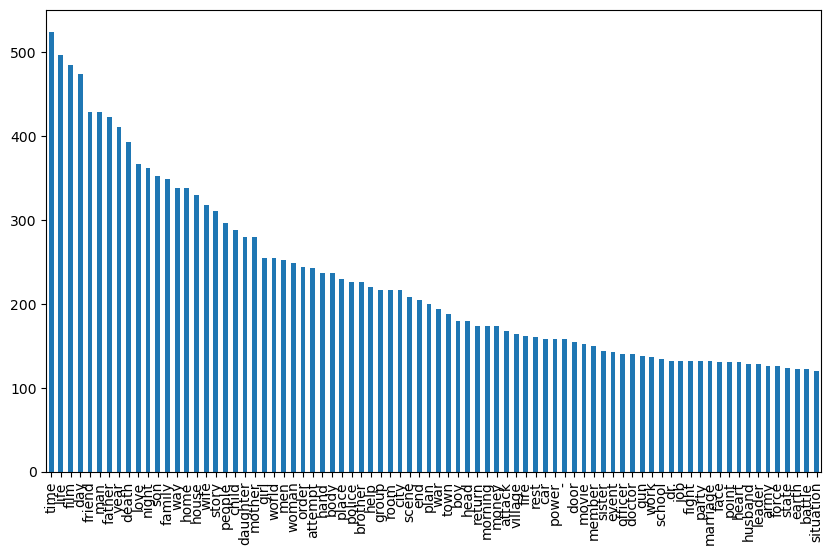

In [58]:
# keep only tags that are in more than two genres
tags_df = tags_df[tags_df.sum(axis=1) > 1]
tags_df

# delete index when their is no 0 on the row
tags_df = tags_df[(tags_df.T != 0).any()]
tags_df['total'] = tags_df.sum(axis=1)
tags_df.sort_values(by='total', ascending=False).head(10)

# Plot the most common tags
fig, ax = plt.subplots(figsize=(10, 6))
tags_df.sort_values(by='total', ascending=False)['total'].head(80).plot(kind='bar', ax=ax)

### Try taking intersection of the 3 methods to take only the relevant tags for each genre

- We observe that the intersection between all 3 methods are very small sets.
- It shows that these methodologies are very different.
- We need to evaluate the methods based on a metric, to find the best ones.


In [57]:
tags_intersection = dict()

for genre in df_movie['Top_genres'].unique():
    
    tags_lda = tags_4_df[genre].values.tolist()
    tags_empath_2 = tags_empath[genre].most_common(1000)
    tags_empath_2 = [tag for tag, _ in tags_empath_2]
    tags_spacy = tags_df[genre].sort_values(ascending=False).index.tolist()[:10000]

    # Taking intersection of tags from all three methods
    tags = list(set(tags_lda) & set(tags_empath_2) & set(tags_spacy))
    tags_intersection[genre] = tags

    print(f"Number of tags in {genre}: {len(tags)}")    

# Create a DataFrame from the tags dictionary
tags_intersection_df = pd.DataFrame.from_dict(tags_intersection, orient='index').fillna(0).T
tags_intersection_df

Number of tags in Drama: 5
Number of tags in Other: 4
Number of tags in Family: 7
Number of tags in Fiction: 3
Number of tags in Action_Adventure: 4
Number of tags in Horror: 2


,Drama,Other,Family,Fiction,Action_Adventure,Horror
0,prison,war,order,home,help,family
1,family,work,help,power,love,child
2,love,family,fight,ship,death,0
3,friend,music,child,0,war,0
4,death,0,home,0,0,0
5,0,0,money,0,0,0
6,0,0,friend,0,0,0


#### Creating Wordclouds for each genre

In [41]:
# Using LDA to extract tags and concepts

output_directory = "../Graph pictures/wordclouds/lda/"

for genre in df_movie['Top_genres'].unique():
    tag_counts = tags_3[genre]
    # Create a word cloud
    try:
        wordcloud_dict = {word: weight for word, weight in tag_counts}
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_dict)

        # Plot the WordCloud image
        plt.figure(figsize=(8, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Tags and Concepts in {genre}")
        figure_filename = f"{output_directory}{genre}_wordcloud.png"
        plt.savefig(figure_filename, bbox_inches='tight')
        plt.close()
        #plt.show()
        
    except Exception as e:
        print(f"Error for {genre}. Error: {e}")

In [40]:
# Using SpaCy to extract tags and concepts

output_directory = "../Graph pictures/wordclouds/SpaCy/"

for genre in df_movie['Top_genres'].unique():
    tag_counts = tags[genre]
    # Create a word cloud
    try:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_counts)
        # Plot the WordCloud image
        plt.figure(figsize=(6, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Tags and Concepts in {genre}")
        figure_filename = f"{output_directory}{genre}_wordcloud.png"
        plt.savefig(figure_filename, bbox_inches='tight')
        plt.close()
        #plt.show()
        
    except Exception as e:
        print(f"No tags for {genre}. Error: {e}")

In [45]:
# Using empath to extract tags and concepts

output_directory = "../Graph pictures/wordclouds/empath/"

for genre in df_movie['Top_genres'].unique():
    tag_counts = tags_empath[genre]
    # Create a word cloud
    try:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_counts)
        # Plot the WordCloud image
        plt.figure(figsize=(8, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Tags and Concepts in {genre}")
        figure_filename = f"{output_directory}{genre}_wordcloud.png"
        plt.savefig(figure_filename, bbox_inches='tight')
        plt.close()
        #plt.show()
        
    except Exception as e:
        print(f"No tags for {genre}. Error: {e}")

## Conclusions on Part I

| Method | Positive | Negative |
|----------|----------|----------|
|Stopwords only|-|Not relevant methodology to extract themes|
|SpaCy|Allows to extract entities and nouns  |Many common words to all genres |
|Empath|analyzes text across lexical categories and generates new lexical categories. Small number of relevant keywords|Many common words to all genres |
|LDA|Adds a significance value for each tag |Many common words to all genres  |

It is difficult to introduce a metric to evaluate all three methods. 
We have therefore plot the worclouds for each method and chose to keep **Empath** Method, which gave the most "plausible" keywords, based on the genre of the movies. We should however note that this is only based on our judgement, which is subjective. 

**Example of analysis for family movies**

Family films are centered on heartwarming stories that emphasize familial relationships. Plots center on the joys and tribulations of family life, with a particular emphasis on children. Weddings, homes, and happy feelings are among the themes used to create an upbeat mood. Friendship, celebrations, and optimism are important themes, while musical components offer entertainment value. These films strike a balance between relatable experiences like school and youth with positive values like helping, giving, and leadership. Despite occasional setbacks, Family films promote unity and the continuing strength of familial bonds, providing wholesome and entertaining experiences for people of all ages.

# Part II: Natural language text generation of new plots based on key tags

- Using openAI API, we try to generate new movie plots for each genre, based on the selection of tags for each genre.

- This part only aims to show that we could use Large language models to generate new ideas of movies.

In [65]:
import os
from openai import OpenAI

client = OpenAI()

# Function to generate movie plot summaries
def generate_movie_summary(tags):
    # Concatenate tags to form a prompt for the model
    prompt = f"Generate a movie plot summary based on the tags: {', '.join(tags)}"

    response = client.completions.create(
    model="gpt-3.5-turbo-instruct",
    max_tokens=200,
    prompt=prompt

    )
    summary = response.choices[0].text
    return summary
# Example: Generate a summary for a specific genre

def genre_summaries():
    plots = {}
    for genre in df_movie['Top_genres'].unique():
        tags_to_generate = tags_df_2[genre].sort_values(ascending=False).index.tolist()[:10]
        generated_summary = generate_movie_summary(tags_to_generate)
        # Print the generated summary
        print(f"Generated Summary for {genre}:{generated_summary}\n")
        plots[genre] = generated_summary

    # Create a DataFrame from the plots dictionary
    plots_df = pd.DataFrame.from_dict(plots, orient='index', columns=['Plot_summary'])
    plots_df.index.name = 'Genre'
    plots_df.to_csv('../Datasets/generated_plots.csv')
    return plots_df

#genre_summaries()

Generated Summary for Drama:


In a small town, a close-knit family struggles to keep their home together amidst the negative emotions caused by the mother's untimely death. The youngest child, a precocious and sensitive boy, seeks solace in the outdoors and occasionally acts out in frustration.

As the family grieves, the town is rocked by a series of suspicious crimes, casting a dark cloud over the once peaceful community. When the town's beloved school teacher is found murdered, tensions rise and suspicions fall on a troubled teenager who has been in and out of the juvenile justice system.

Meanwhile, the oldest daughter prepares to marry her high school sweetheart, bringing the family together for a joyous occasion. But as the wedding day approaches, the secrets of the town start to unravel and the family is forced to confront the painful truth that their late mother may have been involved in the crimes.

As the town becomes consumed by fear and anger, the family must band together

# Part III: Sentiment analysis of plots

We want to add a sentiment score to all plots and try to find significant relationship between the genres dans the scores.

In [106]:
#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# avoid multiple calculations
from cache_to_disk import cache_to_disk

In [107]:
# We take a sample of 1000 movies

df_movie_2 = df_movie[df_movie['Top_genres'] != "Other"] # we remove the "Other" genre

df_sentiment = df_movie_2[['Movie_name', 'Plot_summary', 'Top_genres','averageRating']].copy().sample(1000, random_state=42)
df_sentiment.head()

,Movie_name,Plot_summary,Top_genres,averageRating
31489,Raja Aur Runk,Raja Aur Runk is the story of a prince and a p...,Family,6.8
32152,The Black Corsair,"Emilio di Roccanera, The Black Corsair, seeks ...",Action_Adventure,6.3
14678,Spies Like Us,"Austin Millbarge is a geekish, basement-dwelli...",Action_Adventure,6.4
11455,Vacation with Derek,Casey and Derek are back and continue their si...,Family,NaN
26614,Live Free or Die Hard,The Federal Bureau of Investigation responds ...,Drama,7.1


In [108]:
@cache_to_disk(1)
def apply_sentiment_scoring(df_sentiment):
    analyzer = SentimentIntensityAnalyzer()
    df_sentiment['neg'] = df_sentiment['Plot_summary'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
    df_sentiment['neu'] = df_sentiment['Plot_summary'].apply(lambda x: analyzer.polarity_scores(x)['neu'])
    df_sentiment['pos'] = df_sentiment['Plot_summary'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
    df_sentiment['compound'] = df_sentiment['Plot_summary'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

    return df_sentiment

df_sentiment = apply_sentiment_scoring(df_sentiment)

In [109]:
df_sentiment

,Movie_name,Plot_summary,Top_genres,averageRating,neg,neu,pos,compound
31489,Raja Aur Runk,Raja Aur Runk is the story of a prince and a p...,Family,6.8,0.079,0.871,0.050,-0.7958
32152,The Black Corsair,"Emilio di Roccanera, The Black Corsair, seeks ...",Action_Adventure,6.3,0.336,0.664,0.000,-0.8442
14678,Spies Like Us,"Austin Millbarge is a geekish, basement-dwelli...",Action_Adventure,6.4,0.081,0.835,0.084,-0.4404
11455,Vacation with Derek,Casey and Derek are back and continue their si...,Family,NaN,0.073,0.776,0.151,0.9192
26614,Live Free or Die Hard,The Federal Bureau of Investigation responds ...,Drama,7.1,0.141,0.793,0.066,-0.9970
...,...,...,...,...,...,...,...,...
19192,The End of Innocence,A young girl is spiritually torn apart by forc...,Drama,5.2,0.159,0.771,0.070,-0.4588
19693,Romance on the High Seas,Elvira Kent and her husband Michael suspect ...,Family,7.0,0.067,0.783,0.150,0.9796
750,Larceny on the Air,Dr. Lawrence Baxter runs a medical-themed radi...,Drama,5.3,0.113,0.787,0.100,-0.1779
2108,Night Editor,"Crane Stewart , the editor of the New York Sta...",Drama,6.7,0.144,0.788,0.068,-0.8948


<Axes: xlabel='neg', ylabel='pos'>

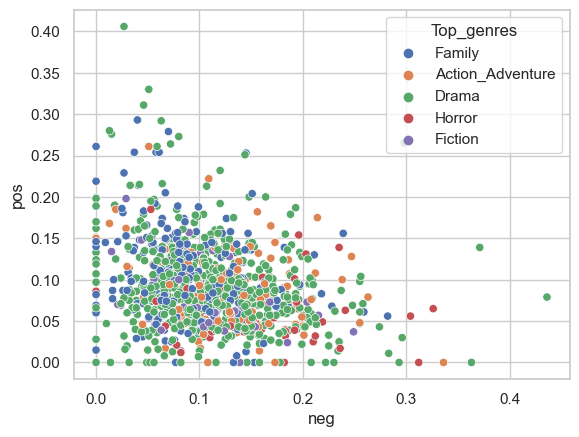

In [94]:
# plot on a graph

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# plot neg vs pos
sns.scatterplot(data=df_sentiment, x="neg", y="pos", hue="Top_genres")

<Axes: xlabel='neg', ylabel='pos'>

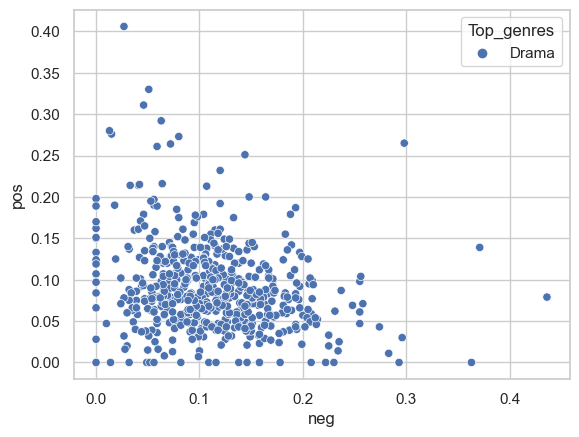

In [114]:
sns.scatterplot(data=df_sentiment[df_sentiment["Top_genres"]=="Drama"], x="neg", y="pos", hue="Top_genres")

<Axes: xlabel='compound', ylabel='averageRating'>

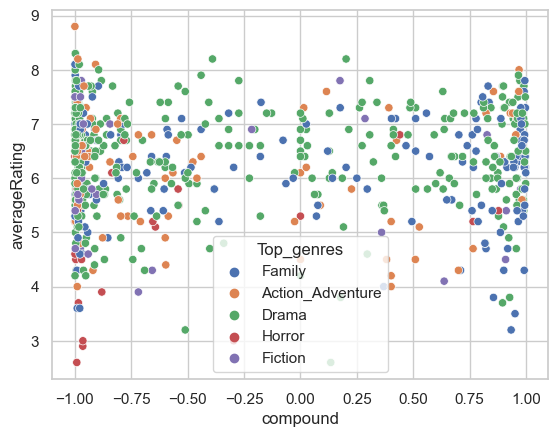

In [95]:
# plot compound vs averageRating
sns.scatterplot(data=df_sentiment, x="compound", y="averageRating", hue="Top_genres")

## Conclusions on Part III:

- The plots don't seem to convey any relevant relationship between score and genres.

In [77]:
df_sentiment.to_csv('../Datasets/sentiment_scores.csv', index=False)

# Causal Analysis

## Propensity score matching

In this notebook, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from cache_to_disk import cache_to_disk


In [9]:
df_movie = pd.read_csv('../Datasets/movies_cleaned_dataset.csv')
df_movie.Top_genres.replace('Action/Adventure', 'Action_Adventure', inplace=True)

In [12]:
columns_causal = ['Movie_name', 'Movie_runtime', 'Main_language', 'Top_genres',
       'Main_country', 'Main_continent', 'Release_Date','averageRating', 'numVotes', 
       'Oscar_Wins', 'Nominations', 'Inflation_adjusted_profit', 'Director_name'] # columns to be used for causal inference

df_causal = df_movie[columns_causal]
df_causal = df_causal[df_causal['Inflation_adjusted_profit']>1000].reindex() # remove movies with profit less than 1000
df_causal = df_causal.dropna() # drop rows with missing values     
df_causal


,Movie_name,Movie_runtime,Main_language,Top_genres,Main_country,Main_continent,Release_Date,averageRating,numVotes,Oscar_Wins,Nominations,Inflation_adjusted_profit,Director_name
5,Henry V,137.0,English Language,Drama,United Kingdom,Europe,1989,7.5,31193.0,1,3,2.217323e+06,Kenneth Branagh
8,Mary Poppins,139.0,English Language,Family,United States of America,USA,1964,7.8,181710.0,5,13,7.348061e+08,Robert Stevenson
12,Baby Boy,123.0,English Language,Drama,United States of America,USA,2001,6.4,16026.0,0,0,1.789112e+07,John Singleton
22,The Gods Must Be Crazy,109.0,Multilingual,Action_Adventure,South Africa,Africa,1980,7.3,58570.0,0,0,8.426204e+07,Jamie Uys
24,Kinjite: Forbidden Subjects,97.0,English Language,Action_Adventure,United States of America,USA,1989,5.5,3701.0,0,0,6.525069e+06,J. Lee Thompson
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42117,Twister,113.0,English Language,Action_Adventure,United States of America,USA,1996,6.5,207675.0,0,0,6.074566e+08,Jan de Bont
42122,How to Eat Fried Worms,98.0,English Language,Family,United States of America,USA,2006,5.3,5882.0,0,0,1.531395e+07,Bob Dolman
42126,Eternally Yours,91.0,English Language,Drama,United States of America,USA,1939,5.7,825.0,0,0,1.162769e+07,Tay Garnett
42133,Coming to America,117.0,English Language,Drama,United States of America,USA,1988,7.1,218808.0,0,0,4.999682e+08,John Landis


## Exploring relationship between winning an award and profit

### Naive approach

In [13]:
awarded = df_causal[df_causal['Oscar_Wins']>0]
not_awarded = df_causal[df_causal['Oscar_Wins']==0]

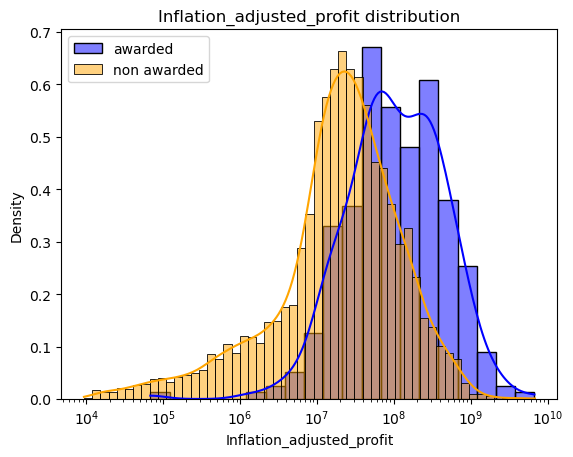

In [60]:
ax = sns.histplot(awarded['Inflation_adjusted_profit'], kde=True, stat='density', color='blue', label='awarded', log_scale=True)
ax = sns.histplot(not_awarded['Inflation_adjusted_profit'], kde=True, stat='density', color='orange', label='non awarded', log_scale=True)
ax.set(xlabel='Inflation_adjusted_profit', ylabel='Density')
plt.title('Inflation_adjusted_profit distribution')
plt.legend()
plt.show()

### Propensity score model

In [52]:
# let's standardize the continuous features

df_causal['Movie_runtime'] = (df_causal['Movie_runtime'] - df_causal['Movie_runtime'].mean())/df_causal['Movie_runtime'].std()
df_causal['averageRating'] = (df_causal['averageRating'] - df_causal['averageRating'].mean())/df_causal['averageRating'].std()
df_causal['numVotes'] = (df_causal['numVotes'] - df_causal['numVotes'].mean())/df_causal['numVotes'].std()
df_causal['Was_awarded'] = df_causal['Oscar_Wins'].apply(lambda x: 1 if x>0 else 0)

- For the moment we don't take into account the *Director_name* and *Main_country*, and *Main_language*
- Th p-values for *C(Main_language)* are all equal to 1: indeed the Oscars dataset contains only for english language movies. We delete this driver
- The p-alues are also nearly equal to 1 for all *Main_country*: so we delete this driver

In [32]:
mod = smf.logit(formula='Was_awarded ~ Movie_runtime + Release_Date + averageRating + numVotes +  C(Top_genres)', data=df_causal)

res = mod.fit()

# Extract the estimated propensity scores
df_causal['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.175976
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            Was_awarded   No. Observations:                 4276
Model:                          Logit   Df Residuals:                     4266
Method:                           MLE   Df Model:                            9
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.3324
Time:                        18:04:43   Log-Likelihood:                -752.47
converged:                       True   LL-Null:                       -1127.2
Covariance Type:            nonrobust   LLR p-value:                1.578e-155
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   46.8599      6.406      7.315      0.000      34.304

In [33]:
df_causal.head()

,Movie_name,Movie_runtime,Main_language,Top_genres,Main_country,Main_continent,Release_Date,averageRating,numVotes,Oscar_Wins,Nominations,Inflation_adjusted_profit,Director_name,Was_awarded,Propensity_score
5,Henry V,1.728416,English Language,Drama,United Kingdom,Europe,1989,1.165055,-0.263915,1,3,-0.346264,Kenneth Branagh,1,0.246697
8,Mary Poppins,1.836881,English Language,Family,United States of America,USA,1964,1.489820,0.634445,5,13,2.830084,Robert Stevenson,1,0.651698
12,Baby Boy,0.969163,English Language,Drama,United States of America,USA,2001,-0.025747,-0.354440,0,0,-0.278305,John Singleton,0,0.019766
22,The Gods Must Be Crazy,0.209909,Multilingual,Action_Adventure,South Africa,Africa,1980,0.948546,-0.100516,0,0,0.009465,Jamie Uys,0,0.106749
24,Kinjite: Forbidden Subjects,-0.440879,English Language,Action_Adventure,United States of America,USA,1989,-1.000040,-0.428001,0,0,-0.327586,J. Lee Thompson,0,0.002181


### Balancing the dataset via matching

We use the propensity scores to match each data point from the awarded group with exactly one data point from the non-awarded group, while ensuring that each data point from the awarded group is matched with at most one data point from the non-awarded group.

For this task, we implement the simplest, full optimal matching, and analyse the results.

In order to perform matching between pairs, a distance/similarity function is needed. Since the library used for the matching (networkx) has a function that maximizes the sum of weights between pairs, it is natural to use a function that measures similarity.

Wanting to minimize the difference of propensity scores between pairs, we define the similarity function between two instances $x$ and $y$ like:

$$ similarity(x,y) = 1 - | propensity\_score(x) - propensity\_score(y) |$$
This function captures the difference in scores like a distance, but since the distance defined like that would always be between 0 and 1, subtracting it from 1 would be a meaningful measure to use for similarity.

In [34]:
@cache_to_disk(1)
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [35]:
# Separate the treatment and control groups
awarded = df_causal[df_causal['Was_awarded'] == 1]
non_awarded = df_causal[df_causal['Was_awarded'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in non_awarded.iterrows():
    for treatment_id, treatment_row in awarded.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [36]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

In [58]:
balanced_df_1 = df_causal.loc[matched]

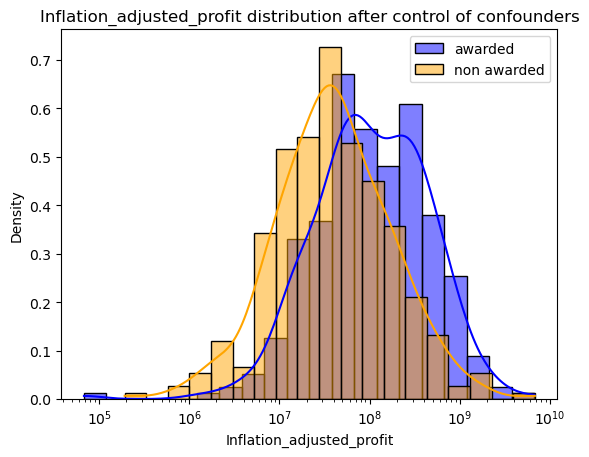

In [59]:
awarded_2 = balanced_df_1[balanced_df_1['Was_awarded']==1]
not_awarded_2 = balanced_df_1[balanced_df_1['Was_awarded']==0]

ax = sns.histplot(awarded_2['Inflation_adjusted_profit'], kde=True, stat='density', color='blue', label='awarded', log_scale=True)
ax = sns.histplot(not_awarded_2['Inflation_adjusted_profit'], kde=True, stat='density', color='orange', label='non awarded', log_scale=True)
ax.set(xlabel='Inflation_adjusted_profit', ylabel='Density')
plt.title('Inflation_adjusted_profit distribution after control of confounders')
plt.legend()
plt.show()

**Comments:**
- The plot after control of coufonder seems to show less evidence of a significantly higher profit for awarded movies compared to non awarded.
- This suggests that there is a correlation link between the cofounders and the movie profits
    - The IMBD has a clean correlation with the profit and with the fact of beeing awarded or not.
    - The release date may also have a link with the inflation adapted profit. We might argue that the movie industry was smaller back then

**Test to be made:**
- Test mean is equal for awarded and non-awarded profit after control

In [65]:
# statistical test to check if the difference in profit between awarded and non awarded movies is significant

from scipy.stats import ttest_ind
awarded_2 = balanced_df_1[balanced_df_1['Was_awarded']==1]
not_awarded_2 = balanced_df_1[balanced_df_1['Was_awarded']==0]
print(ttest_ind(awarded_2['Inflation_adjusted_profit'], not_awarded_2['Inflation_adjusted_profit'])) 

TtestResult(statistic=3.5209307162352554, pvalue=0.00046107971551524507, df=630.0)


The statistical test comparing the inflation-adjusted profits between awarded and non-awarded movies yields a significant result (p-value = 0.00046). This suggests that there is a statistically significant difference in profits between movies that have received awards and those that have not.

In [66]:
# let's check if the difference in profit between awarded and non awarded movies is significant for each genre
for genre in df_causal.Top_genres.unique():
    awarded_2 = balanced_df_1[(balanced_df_1['Was_awarded']==1) & (balanced_df_1['Top_genres']==genre)]
    not_awarded_2 = balanced_df_1[(balanced_df_1['Was_awarded']==0) & (balanced_df_1['Top_genres']==genre)]
    print(genre, ttest_ind(awarded_2['Inflation_adjusted_profit'], not_awarded_2['Inflation_adjusted_profit']))

Drama TtestResult(statistic=4.164437242393042, pvalue=3.887438932180826e-05, df=370.0)
Family TtestResult(statistic=-0.2926187054113165, pvalue=0.7702468493084247, df=140.0)
Action_Adventure TtestResult(statistic=3.1385674367550562, pvalue=0.0024851659231341027, df=70.0)
Fiction TtestResult(statistic=-0.30153876746624225, pvalue=0.7657131922510296, df=23.0)
Horror TtestResult(statistic=1.160434463382617, pvalue=0.2793278614478271, df=8.0)
Other TtestResult(statistic=0.79421490754572, pvalue=0.4475051184712392, df=9.0)


**Difference in Profit by Genre:**

- Drama: There is a significant difference in profits between awarded and non-awarded Drama movies (p-value = 3.89e-05). Awarded Drama movies tend to have significantly higher profits compared to non-awarded ones.
- Family: The difference in profits between awarded and non-awarded Family movies is not statistically significant (p-value = 0.77). This implies that, within the Family genre, receiving awards does not seem to be associated with a significant difference in profits.
- Action/Adventure: Awarded Action/Adventure movies show a significant difference in profits compared to their non-awarded counterparts (p-value = 0.0025). This suggests that, within the Action/Adventure genre, receiving awards is associated with a statistically significant difference in profits.
- Fiction, Horror, Other: The differences in profits for awarded and non-awarded movies within these genres are not statistically significant. This implies that, for Fiction, Horror, and Other genres, there is insufficient evidence to conclude a significant difference in profits based on awards.

## Exploring relationship between beeing awarded and the IMBD rating of the movie

### Naive approach

In [57]:
columns_causal = ['Movie_name', 'Movie_runtime', 'Main_language', 'Top_genres',
       'Main_country', 'Main_continent', 'Release_Date','averageRating', 'numVotes', 
       'Oscar_Wins', 'Nominations', 'Inflation_adjusted_profit', 'Director_name'] # columns to be used for causal inference

df_causal = df_movie[columns_causal]
df_causal = df_causal[df_causal['Inflation_adjusted_profit']>1000].reindex() # remove movies with profit less than 1000
df_causal['Was_awarded'] = df_causal['Oscar_Wins'].apply(lambda x: 1 if x>0 else 0)
df_causal = df_causal.dropna() # drop rows with missing values     
df_causal.head()

,Movie_name,Movie_runtime,Main_language,Top_genres,Main_country,Main_continent,Release_Date,averageRating,numVotes,Oscar_Wins,Nominations,Inflation_adjusted_profit,Director_name,Was_awarded
5,Henry V,137.0,English Language,Drama,United Kingdom,Europe,1989,7.5,31193.0,1,3,2.217323e+06,Kenneth Branagh,1
8,Mary Poppins,139.0,English Language,Family,United States of America,USA,1964,7.8,181710.0,5,13,7.348061e+08,Robert Stevenson,1
12,Baby Boy,123.0,English Language,Drama,United States of America,USA,2001,6.4,16026.0,0,0,1.789112e+07,John Singleton,0
22,The Gods Must Be Crazy,109.0,Multilingual,Action_Adventure,South Africa,Africa,1980,7.3,58570.0,0,0,8.426204e+07,Jamie Uys,0
24,Kinjite: Forbidden Subjects,97.0,English Language,Action_Adventure,United States of America,USA,1989,5.5,3701.0,0,0,6.525069e+06,J. Lee Thompson,0


In [48]:
awarded = df_causal[df_causal['Oscar_Wins']>0]
not_awarded = df_causal[df_causal['Oscar_Wins']==0]

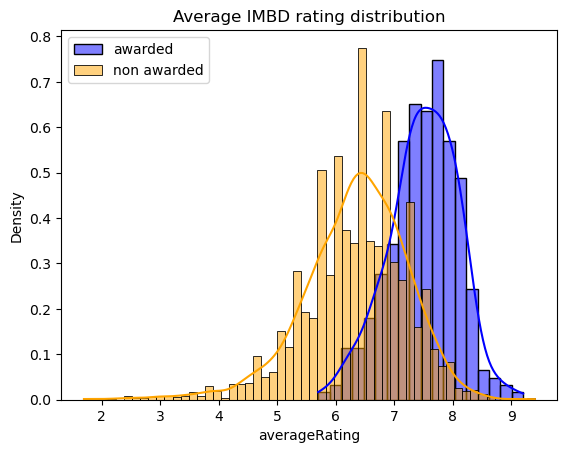

In [51]:
ax = sns.histplot(awarded['averageRating'], kde=True, stat='density', color='blue', label='awarded', log_scale=False)
ax = sns.histplot(not_awarded['averageRating'], kde=True, stat='density', color='orange', label='non awarded', log_scale=False)
ax.set(xlabel='averageRating', ylabel='Density')
plt.title('Average IMBD rating distribution')
plt.legend()
plt.show()

### Propensity score model

In [67]:
# let's standardize the continuous features

df_causal['Movie_runtime'] = (df_causal['Movie_runtime'] - df_causal['Movie_runtime'].mean())/df_causal['Movie_runtime'].std()
df_causal['numVotes'] = (df_causal['numVotes'] - df_causal['numVotes'].mean())/df_causal['numVotes'].std()
df_causal['Inflation_adjusted_profit'] = (df_causal['Inflation_adjusted_profit'] - df_causal['Inflation_adjusted_profit'].mean())/df_causal['Inflation_adjusted_profit'].std()

- For the moment we don't take into account the *Director_name* and *Main_country*, and *Main_language*
- Th p-values for *C(Main_language)* are all equal to 1: indeed the Oscars dataset contains only for english language movies. We delete this driver
- The p-alues are also nearly equal to 1 for all *Main_country*: so we delete this driver

In [68]:
mod = smf.logit(formula='Was_awarded ~ Movie_runtime + Release_Date + Inflation_adjusted_profit + numVotes +  C(Top_genres)', data=df_causal)

res = mod.fit()

# Extract the estimated propensity scores
df_causal['Propensity_score'] = res.predict()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.203257
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            Was_awarded   No. Observations:                 4276
Model:                          Logit   Df Residuals:                     4266
Method:                           MLE   Df Model:                            9
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.2290
Time:                        18:35:34   Log-Likelihood:                -869.13
converged:                       True   LL-Null:                       -1127.2
Covariance Type:            nonrobust   LLR p-value:                1.974e-105
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    78.2124      6.034     12.963      0.000      66.

### Computing propensity scores

In [74]:
# Separate the treatment and control groups
awarded = df_causal[df_causal['Was_awarded'] == 1]
non_awarded = df_causal[df_causal['Was_awarded'] == 0]

# Create an empty undirected graph
G2 = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in non_awarded.iterrows():
    for treatment_id, treatment_row in awarded.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G2.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G2)

In [75]:
matched2 = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
balanced_df_2 = df_causal.loc[matched2]

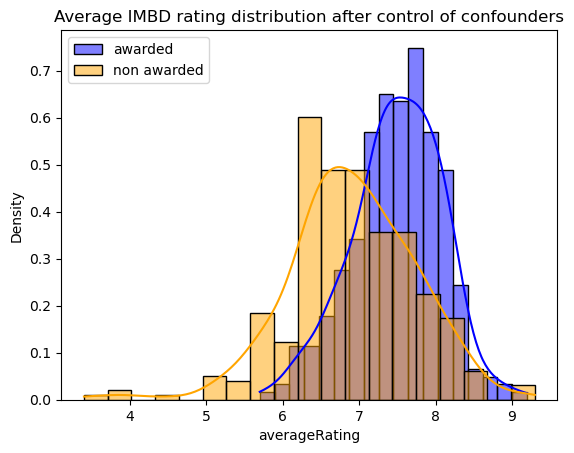

In [78]:
awarded_3 = balanced_df_2[balanced_df_2['Was_awarded']==1]
not_awarded_3 = balanced_df_2[balanced_df_2['Was_awarded']==0]

ax = sns.histplot(awarded_3['averageRating'], kde=True, stat='density', color='blue', label='awarded', log_scale=False)
ax = sns.histplot(not_awarded_3['averageRating'], kde=True, stat='density', color='orange', label='non awarded', log_scale=False)
ax.set(xlabel='averageRating', ylabel='Density')
plt.title('Average IMBD rating distribution after control of confounders')
plt.legend()
plt.show()

In [79]:
# statistical test to check if the difference in IMBD rating between awarded and non awarded movies is significant

from scipy.stats import ttest_ind
awarded_3 = balanced_df_2[balanced_df_2['Was_awarded']==1]
not_awarded_3 = balanced_df_2[balanced_df_2['Was_awarded']==0]
print(ttest_ind(awarded_3['averageRating'], not_awarded_3['averageRating'])) 

TtestResult(statistic=10.175456667055386, pvalue=1.2792665695538858e-22, df=630.0)


In [80]:
# let's check if the difference in IMBD rating between awarded and non awarded movies is significant for each genre
for genre in df_causal.Top_genres.unique():
    awarded_3 = balanced_df_2[(balanced_df_2['Was_awarded']==1) & (balanced_df_2['Top_genres']==genre)]
    not_awarded_3 = balanced_df_2[(balanced_df_2['Was_awarded']==0) & (balanced_df_2['Top_genres']==genre)]
    print(genre, ttest_ind(awarded_3['averageRating'], not_awarded_3['averageRating']))

Drama TtestResult(statistic=8.226459644059743, pvalue=3.412944919704113e-15, df=366.0)
Family TtestResult(statistic=5.371259923414913, pvalue=3.09388227870342e-07, df=143.0)
Action_Adventure TtestResult(statistic=3.2693918068811536, pvalue=0.0016829009395072589, df=69.0)
Fiction TtestResult(statistic=0.39610678227782137, pvalue=0.6964393230790848, df=19.0)
Horror TtestResult(statistic=1.749612823825816, pvalue=0.11411321021251909, df=9.0)
Other TtestResult(statistic=2.0477863301025647, pvalue=0.05982210429364817, df=14.0)


## Exploring relationship between beeing awarded and having a well-known producer

In [ ]:
df_causal.Director_name.value_counts()

Director_name
Woody Allen             19
Steven Spielberg        19
Clint Eastwood          18
Alfred Hitchcock        17
George Cukor            16
                        ..
Im Kyung-soo             1
Dennis Gansel            1
Alan Poul                1
Robert C. Ramirez        1
Patrick Read Johnson     1
Name: count, Length: 2075, dtype: int64

In [ ]:
df_awarded = df_causal[df_causal['Oscar_Wins']>0] # movies with at least one oscar

In [ ]:
df_directors = df_awarded.Director_name.value_counts()
df_directors

# Cast creation algorithm

This code first 

In [124]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [ ]:
# Read in data
roles = pd.read_csv('principal_actors.csv')
data = pd.read_csv('movies_cleaned_dataset_old.csv')

In [126]:
data

,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_genres,Main_genre,Main_language,Top_genres,Main_country,Main_continent,Plot_summary,...,averageRating,numVotes,Estimated_Budget,IMDb,Oscar_Wins,Nominations,Profit,Inflation_adjusted_profit,nconst,Director_name
0,Ghosts of Mars,14010832,98.0,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","['Thriller', 'Science Fiction', 'Horror', 'Adv...",English Language,Thriller,United States of America,USA,"Set in the second half of the 22nd century, th...",...,4.9,56894.0,28000000,tt0228333,0,0,-13989168,-1.870336e+07,nm0000118,John Carpenter
1,White Of The Eye,0,110.0,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","['Thriller', 'Erotic thriller', 'Psychological...",English Language,Thriller,United Kingdom,Europe,A series of murders of rich young women throug...,...,6.1,2894.0,0,tt0094320,0,0,0,0.000000e+00,nm0131910,Donald Cammell
2,A Woman in Flames,0,106.0,"{""/m/07s9rl0"": ""Drama""}",Drama,German Language,Other,Germany,Europe,"Eva, an upper class housewife, becomes frustra...",...,5.9,623.0,0,tt0083949,0,0,0,0.000000e+00,nm0885554,Robert van Ackeren
3,The Sorcerer's Apprentice,0,86.0,"{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","['Family Film', 'Fantasy', 'Adventure', 'World...",English Language,Family Film,South Africa,Africa,"Every hundred years, the evil Morgana returns...",...,NaN,NaN,0,NaN,0,0,0,0.000000e+00,NaN,Unknown
4,Little city,0,93.0,"{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","['Romantic comedy', 'Ensemble Film', 'Comedy-d...",English Language,Drama,United States of America,USA,"Adam, a San Francisco-based artist who works a...",...,5.8,1129.0,0,tt0119548,0,0,0,0.000000e+00,nm0070142,Roberto Benabib
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42150,The Ghost Train,0,82.0,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...","['Crime Fiction', 'Thriller', 'Comedy', 'Super...",English Language,Thriller,United Kingdom,Europe,{{plot}} The film opens with a Great Western e...,...,6.2,1582.0,0,tt0033660,0,0,0,0.000000e+00,nm0285962,Walter Forde
42151,Mermaids: The Body Found,0,120.0,"{""/m/07s9rl0"": ""Drama""}",Drama,English Language,Other,United States of America,USA,Two former National Oceanic Atmospheric Admini...,...,NaN,NaN,0,NaN,0,0,0,0.000000e+00,NaN,Unknown
42152,Knuckle,0,96.0,"{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...","['Biographical film', 'Drama', 'Documentary']",English Language,Drama,Ireland,NaN,{{No plot}} This film follows 12 years in the ...,...,6.8,3193.0,0,tt1606259,0,0,0,0.000000e+00,nm3817974,Ian Palmer
42153,The Super Dimension Fortress Macross II: Lover...,0,150.0,"{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...","['Science Fiction', 'Japanese Movies', 'Advent...",Japanese Language,Science Fiction,Japan,Asia,"The story takes place in the year 2092,The Sup...",...,NaN,NaN,0,NaN,0,0,0,0.000000e+00,NaN,Unknown


In [127]:
data[data['tconst'] == "tt0468569"]

,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_genres,Main_genre,Main_language,Top_genres,Main_country,Main_continent,Plot_summary,...,averageRating,numVotes,Estimated_Budget,IMDb,Oscar_Wins,Nominations,Profit,Inflation_adjusted_profit,nconst,Director_name
19714,The Dark Knight,1004558444,153.0,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...","['Crime Fiction', 'Thriller', 'Superhero movie...",Multilingual,Thriller,United States of America,NaN,"In Gotham City, the Joker and his accomplices...",...,9.0,2797575.0,185000000,tt0468569,2,8,819558444,9.011466e+08,nm0634240,Christopher Nolan


# Define genre here

In [128]:
roles

,tconst,ordering,nconst,category,characters,primaryName,birthYear,deathYear
0,tt0000005,1,nm0443482,actor,"[""Blacksmith""]",Charles Kayser,1878,1966
1,tt0000005,2,nm0653042,actor,"[""Assistant""]",John Ott,1850,1931
2,tt0000007,1,nm0179163,actor,\N,James J. Corbett,1866,1933
3,tt0000007,2,nm0183947,actor,\N,Peter Courtney,1867,1896
4,tt0000008,1,nm0653028,actor,"[""Sneezing Man""]",Fred Ott,1860,1936
...,...,...,...,...,...,...,...,...
12181807,tt9916856,4,nm10538647,actress,"[""Kathi""]",Kathrin Knöpfle,\N,\N
12181808,tt9916880,1,nm2784764,actress,"[""Henry""]",Lizzie Waterworth,\N,\N
12181809,tt9916880,2,nm1483166,actor,"[""Rude Ralph"",""Mischievous Mike"",""Jolly Josh""]",Aidan Cook,\N,\N
12181810,tt9916880,3,nm0254176,actress,"[""Moody Margaret""]",Sue Elliott-Nichols,\N,\N


In [50]:
# Get role counts

role_counts = roles.groupby(['nconst', 'category', 'ordering']).size().unstack(fill_value=0)

# Reset index so we can join on 'nconst'
role_counts.reset_index(inplace=True)

# Get actor details
actor_details = roles[['nconst', 'primaryName', 'birthYear', 'deathYear']].drop_duplicates()

# Join the actor details with their role counts
actor_role_df = actor_details.merge(role_counts, on='nconst')

actor_role_df

,nconst,primaryName,birthYear,deathYear,category,1,2,3,4
0,nm0443482,Charles Kayser,1878,1966,actor,1,0,0,0
1,nm0653042,John Ott,1850,1931,actor,0,1,0,0
2,nm0179163,James J. Corbett,1866,1933,actor,2,0,0,0
3,nm0183947,Peter Courtney,1867,1896,actor,0,1,0,0
4,nm0653028,Fred Ott,1860,1936,actor,1,0,0,0
...,...,...,...,...,...,...,...,...,...
1680361,nm13233318,Ganesh Vasant Patil,\N,\N,actor,0,0,1,0
1680362,nm10538641,Yvonne Akins,\N,\N,actor,1,0,0,0
1680363,nm10538650,Anna Fitoussi,\N,\N,actress,0,1,0,0
1680364,nm10538646,Andreas Demmel,\N,\N,actor,0,0,1,0


In [52]:
# Rename columns to represent role counts
actor_role_df.rename(columns={
    'primaryName': 'name',
    1: 'first_roles',
    2: 'second_roles',
    3: 'third_roles',
    4: 'fourth_roles',
}, inplace=True)

In [53]:
display(actor_role_df[actor_role_df['name'] == 'Christian Bale'])

,nconst,name,birthYear,deathYear,category,first_roles,second_roles,third_roles,fourth_roles
60275,nm0000288,Christian Bale,1974,\N,actor,29,9,9,3


In [54]:
# Get total number of roles for each actor
actor_role_df['total_roles'] = actor_role_df['first_roles'] + actor_role_df['second_roles'] + actor_role_df['third_roles'] + actor_role_df['fourth_roles']

In [129]:
# Map genres to map_genres, cluster the genres into the five ones we want to analyze

drama = ['Drama', 'Crime', 'Thriller']
family = ['Family Film', 'Comedy', 'Musical']
action_adventure = ['Action', 'Action/Adventure']
fiction = ['Science Fiction']
horror = ['Horror']
other = ['Short Film', 'Other']

def map_genre(genre):
    if genre in drama:
        return 'Drama'
    elif genre in family:
        return 'Family'
    elif genre in action_adventure:
        return 'Action/Adventure'
    elif genre in fiction:
        return 'Fiction'
    elif genre in horror:
        return 'Horror'
    else:
        return 'Other'


In [130]:
# Apply the mapping function
data['Top_genres'] = data['Top_genres'].apply(map_genre)

In [135]:
# Dropping the columns we do not need for the ML   
data = data.drop(columns= ['Movie_runtime', 'Inflation_adjusted_profit', 'Main_language', 'Oscar_Wins', 'Nominations', 'averageRating', 'Main_country', 'Main_continent', 'Plot_summary', 'numVotes', 'Estimated_Budget'])

In [137]:
# Dropping the columns we do not need for the ML   
data = data.drop(columns=['Movie_box_office_revenue', 'Main_genre', 'Movie_genres', 'IMDb', 'Profit'])

In [62]:

def map_role(tconst):
    # Get the first, second, third, and fourth billed actors
    return roles[(roles['ordering'] == 1) & (roles['tconst'] == tconst)]['nconst'], roles[(roles['ordering'] == 2) & (roles['tconst'] == tconst)]['nconst'], roles[(roles['ordering'] == 3) & (roles['tconst'] == tconst)]['nconst'], roles[(roles['ordering'] == 4) & (roles['tconst'] == tconst)]['nconst']
    

In [63]:
# Get the first, second, third, and fourth billed actors
roles = roles.drop(columns=['category', 'primaryName', 'birthYear', 'deathYear', 'characters'])
roles_pivot = roles.pivot(index='tconst', columns='ordering', values='nconst')

# Rename the columns for clarity
roles_pivot.columns = [f'role_{i}' for i in range(1, 5)]

In [64]:
roles_pivot

,role_1,role_2,role_3,role_4
tconst,,,,
tt0000005,nm0443482,nm0653042,NaN,NaN
tt0000007,nm0179163,nm0183947,NaN,NaN
tt0000008,nm0653028,NaN,NaN,NaN
tt0000009,nm0063086,nm0183823,nm1309758,NaN
tt0000011,nm3692297,NaN,NaN,NaN
...,...,...,...,...
tt9916848,nm5262613,nm3665668,nm8250913,nm8690065
tt9916850,nm5262613,nm3665668,nm8250913,nm8690065
tt9916852,nm5262613,nm3665668,nm8250913,nm8690065


In [65]:
# Get the nconst of the top 4 roles of each movie
data = data.merge(roles_pivot, on='tconst')
data

,Movie_name,Top_genres,Release_Date,tconst,nconst,Director_name,capped_profit,Successful,role_1,role_2,role_3,role_4
0,Ghosts of Mars,Drama,2001,tt0228333,nm0000118,John Carpenter,-1.870336e+07,3.9,nm0000449,nm0001084,nm0000427,nm0005458
1,White Of The Eye,Drama,1987,tt0094320,nm0131910,Donald Cammell,0.000000e+00,4.5,nm0001418,nm0001550,nm0742165,nm0262543
2,A Woman in Flames,Other,1983,tt0083949,nm0885554,Robert van Ackeren,0.000000e+00,4.4,nm0484727,nm0140649,nm0957193,nm0480718
3,Little city,Drama,1997,tt0119548,nm0070142,Roberto Benabib,0.000000e+00,4.4,nm0000954,nm0000542,nm0068725,nm0255588
4,Henry V,Drama,1989,tt0097499,nm0000110,Kenneth Branagh,2.217323e+06,5.5,nm0000110,nm0001394,nm0791871,nm0488289
...,...,...,...,...,...,...,...,...,...,...,...,...
23891,Guilty as Sin,Drama,1993,tt0107057,nm0001486,Sidney Lumet,1.160929e+07,4.6,nm0000360,nm0000467,nm0002332,nm0912001
23892,Into the Mirror,Other,2003,tt0372937,nm1193005,Sung-ho Kim,0.000000e+00,4.5,nm0949167,nm1047988,nm1092665,nm1029669
23893,Gopi Kishan,Drama,1994,tt0109922,nm0240881,Mukesh Duggal,0.000000e+00,4.4,nm0792911,nm0006433,nm0794364,nm0643350
23894,The Ghost Train,Drama,1941,tt0033660,nm0285962,Walter Forde,0.000000e+00,4.5,nm0039450,nm0613768,nm0365692,nm0615333


In [68]:
# Add the birth year of each actor of the top 4 roles
actors_df = actor_role_df[['nconst','birthYear']]
display(actors_df)
def merge_birth_year(df, actors_df, role_column):
    return df.merge(actors_df, left_on = role_column, right_on='nconst', how='left').rename(columns={'birthYear': f'{role_column}_birth_year'})

# Merge for each role
for role in ['role_1', 'role_2', 'role_3', 'role_4']:
    data = merge_birth_year(data, actors_df, role)

,nconst,birthYear
0,nm0443482,1878
1,nm0653042,1850
2,nm0179163,1866
3,nm0183947,1867
4,nm0653028,1860
...,...,...
1680361,nm13233318,\N
1680362,nm10538641,\N
1680363,nm10538650,\N
1680364,nm10538646,\N


/var/folders/qd/996x_2t932b4mbltb5bx_y9r0000gn/T/ipykernel_1307/1909437176.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'nconst_x'} in the result is deprecated and will raise a MergeError in a future version.
  return df.merge(actors_df, left_on = role_column, right_on='nconst', how='left').rename(columns={'birthYear': f'{role_column}_birth_year'})


In [69]:
data

,Movie_name,Top_genres,Release_Date,tconst,nconst_x,Director_name,capped_profit,Successful,role_1,role_2,role_3,role_4,nconst_y,role_1_birth_year,nconst_x,role_2_birth_year,nconst_y,role_3_birth_year,nconst,role_4_birth_year
0,Ghosts of Mars,Drama,2001,tt0228333,nm0000118,John Carpenter,-1.870336e+07,3.9,nm0000449,nm0001084,nm0000427,nm0005458,nm0000449,1974,nm0001084,1969,nm0000427,1949,nm0005458,1967
1,White Of The Eye,Drama,1987,tt0094320,nm0131910,Donald Cammell,0.000000e+00,4.5,nm0001418,nm0001550,nm0742165,nm0262543,nm0001418,1954,nm0001550,1960,nm0742165,1950,nm0262543,1942
2,A Woman in Flames,Other,1983,tt0083949,nm0885554,Robert van Ackeren,0.000000e+00,4.4,nm0484727,nm0140649,nm0957193,nm0480718,nm0484727,1950,nm0140649,1950,nm0957193,1947,nm0480718,\N
3,Little city,Drama,1997,tt0119548,nm0070142,Roberto Benabib,0.000000e+00,4.4,nm0000954,nm0000542,nm0068725,nm0255588,nm0000954,1962,nm0000542,1964,nm0068725,1932,nm0255588,1922
4,Henry V,Drama,1989,tt0097499,nm0000110,Kenneth Branagh,2.217323e+06,5.5,nm0000110,nm0001394,nm0791871,nm0488289,nm0000110,1960,nm0001394,1938,nm0791871,1956,nm0488289,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23891,Guilty as Sin,Drama,1993,tt0107057,nm0001486,Sidney Lumet,1.160929e+07,4.6,nm0000360,nm0000467,nm0002332,nm0912001,nm0000360,1959,nm0000467,1949,nm0002332,1952,nm0912001,1920
23892,Into the Mirror,Other,2003,tt0372937,nm1193005,Sung-ho Kim,0.000000e+00,4.5,nm0949167,nm1047988,nm1092665,nm1029669,nm0949167,1976,nm1047988,1972,nm1092665,1980,nm1029669,1955
23893,Gopi Kishan,Drama,1994,tt0109922,nm0240881,Mukesh Duggal,0.000000e+00,4.4,nm0792911,nm0006433,nm0794364,nm0643350,nm0792911,1961,nm0006433,1974,nm0794364,1969,nm0643350,1946
23894,The Ghost Train,Drama,1941,tt0033660,nm0285962,Walter Forde,0.000000e+00,4.5,nm0039450,nm0613768,nm0365692,nm0615333,nm0039450,1900,nm0613768,1907,nm0365692,1892,nm0615333,1908


In [71]:
# Get the total number of roles of each actor of the top 4 roles
actors_df = actor_role_df[['nconst','total_roles']]
def merge_total_roles(df, actors_df, role_column):
    return df.merge(actors_df, left_on = role_column, right_on='nconst', how='left').rename(columns={'total_roles': f'{role_column}_roles_count'})

# Merge for each role
for role in ['role_1', 'role_2', 'role_3', 'role_4']:
    data = merge_total_roles(data, actors_df, role)

/var/folders/qd/996x_2t932b4mbltb5bx_y9r0000gn/T/ipykernel_1307/2637431196.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'nconst_x'} in the result is deprecated and will raise a MergeError in a future version.
  return df.merge(actors_df, left_on = role_column, right_on='nconst', how='left').rename(columns={'total_roles': f'{role_column}_roles_count'})
/var/folders/qd/996x_2t932b4mbltb5bx_y9r0000gn/T/ipykernel_1307/2637431196.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'nconst_x'} in the result is deprecated and will raise a MergeError in a future version.
  return df.merge(actors_df, left_on = role_column, right_on='nconst', how='left').rename(columns={'total_roles': f'{role_column}_roles_count'})


In [72]:
actor_role_df['category'] = actor_role_df['category'].apply(lambda x: 'M' if x == 'actor' else 'F')

In [74]:
# Add the sex of each actor of the top 4 roles
actors_df = actor_role_df[['nconst','category']]
def merge_sex(df, actors_df, role_column):
    return df.merge(actors_df, left_on = role_column, right_on='nconst', how='left').rename(columns={'category': f'{role_column}_sex'})

# Merge for each role
for role in ['role_1', 'role_2', 'role_3', 'role_4']:
    data = merge_sex(data, actors_df, role)

/var/folders/qd/996x_2t932b4mbltb5bx_y9r0000gn/T/ipykernel_1307/471939116.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'nconst_x'} in the result is deprecated and will raise a MergeError in a future version.
  return df.merge(actors_df, left_on = role_column, right_on='nconst', how='left').rename(columns={'category': f'{role_column}_sex'})
/var/folders/qd/996x_2t932b4mbltb5bx_y9r0000gn/T/ipykernel_1307/471939116.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'nconst_x'} in the result is deprecated and will raise a MergeError in a future version.
  return df.merge(actors_df, left_on = role_column, right_on='nconst', how='left').rename(columns={'category': f'{role_column}_sex'})


In [75]:
data

,Movie_name,Top_genres,Release_Date,tconst,nconst_x,Director_name,capped_profit,Successful,role_1,role_2,...,nconst_x,role_4_roles_count,nconst_y,role_1_sex,nconst_x,role_2_sex,nconst_y,role_3_sex,nconst,role_4_sex
0,Ghosts of Mars,Drama,2001,tt0228333,nm0000118,John Carpenter,-1.870336e+07,3.9,nm0000449,nm0001084,...,nm0005458,53.0,nm0000449,F,nm0001084,M,nm0000427,F,nm0005458,M
1,White Of The Eye,Drama,1987,tt0094320,nm0131910,Donald Cammell,0.000000e+00,4.5,nm0001418,nm0001550,...,nm0262543,25.0,nm0001418,M,nm0001550,F,nm0742165,M,nm0262543,M
2,A Woman in Flames,Other,1983,tt0083949,nm0885554,Robert van Ackeren,0.000000e+00,4.4,nm0484727,nm0140649,...,nm0480718,3.0,nm0484727,F,nm0140649,M,nm0957193,M,nm0480718,F
3,Little city,Drama,1997,tt0119548,nm0070142,Roberto Benabib,0.000000e+00,4.4,nm0000954,nm0000542,...,nm0255588,1.0,nm0000954,M,nm0000542,F,nm0068725,M,nm0255588,M
4,Henry V,Drama,1989,tt0097499,nm0000110,Kenneth Branagh,2.217323e+06,5.5,nm0000110,nm0001394,...,nm0488289,12.0,nm0000110,M,nm0001394,M,nm0791871,M,nm0488289,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23891,Guilty as Sin,Drama,1993,tt0107057,nm0001486,Sidney Lumet,1.160929e+07,4.6,nm0000360,nm0000467,...,nm0912001,204.0,nm0000360,F,nm0000467,M,nm0002332,M,nm0912001,M
23892,Into the Mirror,Other,2003,tt0372937,nm1193005,Sung-ho Kim,0.000000e+00,4.5,nm0949167,nm1047988,...,nm1029669,17.0,nm0949167,M,nm1047988,M,nm1092665,F,nm1029669,M
23893,Gopi Kishan,Drama,1994,tt0109922,nm0240881,Mukesh Duggal,0.000000e+00,4.4,nm0792911,nm0006433,...,nm0643350,35.0,nm0792911,M,nm0006433,F,nm0794364,F,nm0643350,M
23894,The Ghost Train,Drama,1941,tt0033660,nm0285962,Walter Forde,0.000000e+00,4.5,nm0039450,nm0613768,...,nm0615333,6.0,nm0039450,M,nm0613768,M,nm0365692,F,nm0615333,M


In [78]:
data.rename(columns={data.columns[4]: 'Director_id'},inplace=True)

In [81]:
# Drop the useless columns added by the merge
data.drop(data.columns[[12, 14, 16, 18, 20, 22, 24, 26]],axis = 1, inplace = True)

In [87]:
data

,Movie_name,Top_genres,Release_Date,tconst,Director_name,capped_profit,Successful,role_1,role_2,role_3,...,role_3_birth_year,role_4_birth_year,role_1_roles_count,role_2_roles_count,role_3_roles_count,role_4_roles_count,role_1_sex,role_2_sex,role_3_sex,role_4_sex
0,Ghosts of Mars,Drama,2001,tt0228333,John Carpenter,-1.870336e+07,3.9,nm0000449,nm0001084,nm0000427,...,1949,1967,133.0,43.0,52.0,53.0,F,M,F,M
1,White Of The Eye,Drama,1987,tt0094320,Donald Cammell,0.000000e+00,4.5,nm0001418,nm0001550,nm0742165,...,1950,1942,68.0,40.0,115.0,25.0,M,F,M,M
2,A Woman in Flames,Other,1983,tt0083949,Robert van Ackeren,0.000000e+00,4.4,nm0484727,nm0140649,nm0957193,...,1947,\N,76.0,232.0,96.0,3.0,F,M,M,F
3,Little city,Drama,1997,tt0119548,Roberto Benabib,0.000000e+00,4.4,nm0000954,nm0000542,nm0068725,...,1932,1922,21.0,65.0,5.0,1.0,M,F,M,M
4,Henry V,Drama,1989,tt0097499,Kenneth Branagh,2.217323e+06,5.5,nm0000110,nm0001394,nm0791871,...,1956,\N,148.0,187.0,30.0,12.0,M,M,M,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23891,Guilty as Sin,Drama,1993,tt0107057,Sidney Lumet,1.160929e+07,4.6,nm0000360,nm0000467,nm0002332,...,1952,1920,51.0,299.0,78.0,204.0,F,M,M,M
23892,Into the Mirror,Other,2003,tt0372937,Sung-ho Kim,0.000000e+00,4.5,nm0949167,nm1047988,nm1092665,...,1980,1955,60.0,33.0,11.0,17.0,M,M,F,M
23893,Gopi Kishan,Drama,1994,tt0109922,Mukesh Duggal,0.000000e+00,4.4,nm0792911,nm0006433,nm0794364,...,1969,1946,109.0,63.0,793.0,35.0,M,F,F,M
23894,The Ghost Train,Drama,1941,tt0033660,Walter Forde,0.000000e+00,4.5,nm0039450,nm0613768,nm0365692,...,1892,1908,24.0,11.0,41.0,6.0,M,M,F,M


In [88]:
# Create the dataset for the ML model optimizing the casting
data.to_csv('cast_processed_corrected_genres.csv', index=False)

In [104]:
actor_role_df['birthYear'] = actor_role_df['birthYear'].fillna("0")
actor_role_df['birthYear'] = actor_role_df['birthYear'].replace("\\N", "0")
actor_role_df['age'] = 2023 - actor_role_df['birthYear'].astype(int)

In [105]:
actor_role_df

,nconst,name,birthYear,deathYear,category,first_roles,second_roles,third_roles,fourth_roles,total_roles,age
0,nm0443482,Charles Kayser,1878,1966,M,1,0,0,0,1,145
1,nm0653042,John Ott,1850,1931,M,0,1,0,0,1,173
2,nm0179163,James J. Corbett,1866,1933,M,2,0,0,0,2,157
3,nm0183947,Peter Courtney,1867,1896,M,0,1,0,0,1,156
4,nm0653028,Fred Ott,1860,1936,M,1,0,0,0,1,163
...,...,...,...,...,...,...,...,...,...,...,...
1680361,nm13233318,Ganesh Vasant Patil,0,\N,M,0,0,1,0,1,2023
1680362,nm10538641,Yvonne Akins,0,\N,M,1,0,0,0,1,2023
1680363,nm10538650,Anna Fitoussi,0,\N,F,0,1,0,0,1,2023
1680364,nm10538646,Andreas Demmel,0,\N,M,0,0,1,0,1,2023


In [111]:
actors_df_alive = actor_role_df[(actor_role_df['deathYear'] == '\\N') & (actor_role_df['age'] < 105)]


In [112]:
actors_df_alive

,nconst,name,birthYear,deathYear,category,first_roles,second_roles,third_roles,fourth_roles,total_roles,age
1845,nm0209802,Luis de Llano,1945,\N,M,0,1,0,0,1,78
5228,nm0317854,Pilar Gil,1977,\N,F,1,3,0,2,6,46
5252,nm0869732,Cecilia Toussaint,1958,\N,F,4,2,4,0,10,65
5254,nm0650495,Regina Orozco,1964,\N,F,1,4,6,5,16,59
7597,nm1009424,Judi Gassel,1927,\N,F,2,1,0,0,3,96
...,...,...,...,...,...,...,...,...,...,...,...
1680267,nm1320801,Nate Miller,1976,\N,M,0,1,0,0,1,47
1680268,nm1665443,Mikhail Solodko,1967,\N,M,0,0,0,1,1,56
1680279,nm1832009,Ahmet Faik Akinci,1956,\N,M,1,0,0,0,1,67
1680343,nm0508273,Rosa León,1951,\N,F,0,0,2,0,2,72


In [113]:
actors_df_alive.to_csv('actors_alive.csv', index=False)

In [123]:
data

,Movie_name,Top_genres,Release_Date,tconst,Director_name,capped_profit,Successful,role_1,role_2,role_3,...,role_3_birth_year,role_4_birth_year,role_1_roles_count,role_2_roles_count,role_3_roles_count,role_4_roles_count,role_1_sex,role_2_sex,role_3_sex,role_4_sex
0,Ghosts of Mars,Drama,2001,tt0228333,John Carpenter,-1.870336e+07,3.9,nm0000449,nm0001084,nm0000427,...,1949,1967,133.0,43.0,52.0,53.0,F,M,F,M
1,White Of The Eye,Drama,1987,tt0094320,Donald Cammell,0.000000e+00,4.5,nm0001418,nm0001550,nm0742165,...,1950,1942,68.0,40.0,115.0,25.0,M,F,M,M
2,A Woman in Flames,Other,1983,tt0083949,Robert van Ackeren,0.000000e+00,4.4,nm0484727,nm0140649,nm0957193,...,1947,\N,76.0,232.0,96.0,3.0,F,M,M,F
3,Little city,Drama,1997,tt0119548,Roberto Benabib,0.000000e+00,4.4,nm0000954,nm0000542,nm0068725,...,1932,1922,21.0,65.0,5.0,1.0,M,F,M,M
4,Henry V,Drama,1989,tt0097499,Kenneth Branagh,2.217323e+06,5.5,nm0000110,nm0001394,nm0791871,...,1956,\N,148.0,187.0,30.0,12.0,M,M,M,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23891,Guilty as Sin,Drama,1993,tt0107057,Sidney Lumet,1.160929e+07,4.6,nm0000360,nm0000467,nm0002332,...,1952,1920,51.0,299.0,78.0,204.0,F,M,M,M
23892,Into the Mirror,Other,2003,tt0372937,Sung-ho Kim,0.000000e+00,4.5,nm0949167,nm1047988,nm1092665,...,1980,1955,60.0,33.0,11.0,17.0,M,M,F,M
23893,Gopi Kishan,Drama,1994,tt0109922,Mukesh Duggal,0.000000e+00,4.4,nm0792911,nm0006433,nm0794364,...,1969,1946,109.0,63.0,793.0,35.0,M,F,F,M
23894,The Ghost Train,Drama,1941,tt0033660,Walter Forde,0.000000e+00,4.5,nm0039450,nm0613768,nm0365692,...,1892,1908,24.0,11.0,41.0,6.0,M,M,F,M


In [139]:
data.columns

Index(['Movie_name', 'Top_genres', 'Release_Date', 'tconst', 'nconst',
       'Director_name', 'capped_profit', 'Successful'],
      dtype='object')

In [121]:
directors = pd.read_csv('directors.csv')
directors


,nconst,director_name,num_movies,movies,birth_year,death_year
0,nm0000005,Ingmar Bergman,85,"['tt0038468', 'tt0038675', 'tt0039834', 'tt004...",1918,2007
1,nm0000008,Marlon Brando,1,['tt0055257'],1924,2004
2,nm0000009,Richard Burton,1,['tt0062898'],1925,1984
3,nm0000010,James Cagney,1,['tt0050964'],1899,1986
4,nm0000018,Kirk Douglas,1,['tt0073559'],1916,2020
...,...,...,...,...,...,...
686037,nm9993679,Art Jones,1,['tt8744074'],\N,\N
686038,nm9993694,Chinmay Mishra,2,"['tt18361688', 'tt18687502']",\N,\N
686039,nm9993696,Ibrahim-Aloduley,1,['tt8744160'],\N,\N
686040,nm9993708,Eli Bevins,9,"['tt11702702', 'tt11753904', 'tt11772812', 'tt...",\N,\N


In [140]:
directors.drop(columns="movies", inplace=True)
data2 = data.drop(columns='capped_profit')

In [142]:
directors

,nconst,director_name,num_movies,birth_year,death_year
0,nm0000005,Ingmar Bergman,85,1918,2007
1,nm0000008,Marlon Brando,1,1924,2004
2,nm0000009,Richard Burton,1,1925,1984
3,nm0000010,James Cagney,1,1899,1986
4,nm0000018,Kirk Douglas,1,1916,2020
...,...,...,...,...,...
686037,nm9993679,Art Jones,1,\N,\N
686038,nm9993694,Chinmay Mishra,2,\N,\N
686039,nm9993696,Ibrahim-Aloduley,1,\N,\N
686040,nm9993708,Eli Bevins,9,\N,\N


In [143]:
data2 = data2.merge(directors, on='nconst', how='left')

In [149]:
data2.dropna(subset = 'birth_year',inplace=True)
data2.replace("\\N", "0", inplace=True)
data2['Director_age'] = data2['Release_Date'] - data2['birth_year'].astype(int)

In [152]:
data2 = data2[data2['Director_age'] < 105]
data2

,Movie_name,Top_genres,Release_Date,tconst,nconst,Director_name,Successful,director_name,num_movies,birth_year,death_year,Director_age
0,Ghosts of Mars,Drama,2001,tt0228333,nm0000118,John Carpenter,3.9,John Carpenter,32.0,1948,0,53
1,White Of The Eye,Drama,1987,tt0094320,nm0131910,Donald Cammell,4.5,Donald Cammell,5.0,1934,1996,53
2,A Woman in Flames,Other,1983,tt0083949,nm0885554,Robert van Ackeren,4.4,Robert van Ackeren,14.0,1946,0,37
5,Henry V,Drama,1989,tt0097499,nm0000110,Kenneth Branagh,5.5,Kenneth Branagh,23.0,1960,0,29
8,Mary Poppins,Family,1964,tt0058331,nm0829038,Robert Stevenson,8.1,Robert Stevenson,134.0,1905,1986,59
...,...,...,...,...,...,...,...,...,...,...,...,...
42141,Mirage,Drama,1972,tt0068955,nm0324162,Armando Robles Godoy,4.6,Armando Robles Godoy,9.0,1923,2010,49
42143,The Flying Serpent,Drama,1946,tt0038531,nm0627864,Sam Newfield,4.2,Sam Newfield,324.0,1899,1964,47
42145,State and Main,Family,2000,tt0120202,nm0000519,David Mamet,4.8,David Mamet,25.0,1947,0,53
42146,Guilty as Sin,Drama,1993,tt0107057,nm0001486,Sidney Lumet,4.6,Sidney Lumet,154.0,1924,2011,69


In [153]:
data2.to_csv('movies_directors_wit h_genre.csv', index=False)

In [165]:
actor_role_df[actor_role_df['nconst'] == 'nm5397459']

,nconst,name,birthYear,deathYear,category,first_roles,second_roles,third_roles,fourth_roles,total_roles,age
361349,nm5397459,Daisy Ridley,1992,\N,F,24,9,7,0,40,31


In [164]:
import re

file_name = 'top_1000.txt' 

try:
    with open(file_name, 'r') as file:
        data = file.read()
    message = "File read successfully."
except FileNotFoundError:
    data = ""
    message = f"File not found: {file_name}"


# Splitting the data into lines
lines = data.strip().split('\n')

# Extracting IMDb nconst using regular expression
nconsts = []
for line in lines:
    match = re.search(r'nm\d+', line)
    if match:
        nconsts.append(match.group())

# Creating a pandas DataFrame
df = pd.DataFrame(nconsts, columns=['IMDb nconst'])
df


,IMDb nconst
0,nm2394794
1,nm0249291
2,nm0636426
3,nm5397459
4,nm4867258
...,...
990,nm0004757
991,nm0403652
992,nm0005346
993,nm0947338


In [167]:
top1000 = df.merge(actor_role_df, left_on='IMDb nconst', right_on='nconst', how='left')
top1000.sort_values(by='age', ascending=False, inplace=True)

In [173]:
top1000.dropna(subset=['age'], inplace=True)
top1000 = top1000[top1000['age'] < 95]
top1000[top1000['deathYear'] == '\\N']

,IMDb nconst,nconst,name,birthYear,deathYear,category,first_roles,second_roles,third_roles,fourth_roles,total_roles,age
225,nm0000142,nm0000142,Clint Eastwood,1930,\N,M,59.0,203.0,2.0,2.0,266.0,93.0
730,nm0000323,nm0000323,Michael Caine,1933,\N,M,70.0,24.0,15.0,9.0,118.0,90.0
970,nm0001132,nm0001132,Judi Dench,1934,\N,F,154.0,42.0,14.0,10.0,220.0,89.0
466,nm0001749,nm0001749,Maggie Smith,1934,\N,F,18.0,14.0,14.0,4.0,50.0,89.0
798,nm0002663,nm0002663,Diane Ladd,1935,\N,F,11.0,19.0,43.0,20.0,93.0,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...
753,nm5897057,nm5897057,Jaeden Martell,2003,\N,M,3.0,8.0,10.0,3.0,24.0,20.0
36,nm5611121,nm5611121,Millie Bobby Brown,2004,\N,F,10.0,7.0,15.0,25.0,57.0,19.0
860,nm6748436,nm6748436,Dafne Keen,2005,\N,F,17.0,4.0,10.0,1.0,32.0,18.0
718,nm5085683,nm5085683,Mckenna Grace,2006,\N,F,32.0,6.0,6.0,6.0,50.0,17.0


In [175]:
top1000 = top1000[top1000['deathYear'] == '\\N']

In [178]:
top1000[top1000['category'] == 'M']

,IMDb nconst,nconst,name,birthYear,deathYear,category,first_roles,second_roles,third_roles,fourth_roles,total_roles,age
225,nm0000142,nm0000142,Clint Eastwood,1930,\N,M,59.0,203.0,2.0,2.0,266.0,93.0
730,nm0000323,nm0000323,Michael Caine,1933,\N,M,70.0,24.0,15.0,9.0,118.0,90.0
747,nm0000095,nm0000095,Woody Allen,1935,\N,M,39.0,4.0,1.0,1.0,45.0,88.0
792,nm0000164,nm0000164,Anthony Hopkins,1937,\N,M,63.0,36.0,13.0,7.0,119.0,86.0
538,nm0000151,nm0000151,Morgan Freeman,1937,\N,M,58.0,35.0,291.0,144.0,528.0,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...
366,nm4055138,nm4055138,Charlie Plummer,1999,\N,M,13.0,4.0,2.0,16.0,35.0,24.0
417,nm7140802,nm7140802,Gaten Matarazzo,2002,\N,M,1.0,1.0,0.0,0.0,2.0,21.0
176,nm6016511,nm6016511,Finn Wolfhard,2002,\N,M,4.0,35.0,27.0,13.0,79.0,21.0
753,nm5897057,nm5897057,Jaeden Martell,2003,\N,M,3.0,8.0,10.0,3.0,24.0,20.0


In [179]:
# saving the dataframe
top1000.to_csv('top1000_actors.csv', index=False)

## Cleaning director data

This code aims to preprocess the information on directors to be used after.


In [1]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [71]:
# Read in the data
director_df = pd.read_csv('directors.csv')
data = pd.read_csv('movies_cleaned_dataset.csv')

In [72]:
from scipy.stats import zscore

# Filling missing values in specific columns with the mean of those columns
data['Inflation_adjusted_profit'].fillna(data['Inflation_adjusted_profit'].mean(), inplace=True)
data['averageRating'].fillna(data['averageRating'].mean(), inplace=True)
data['Oscar_Wins'].fillna(data['Oscar_Wins'].mean(), inplace=True)
data['Nominations'].fillna(data['Nominations'].mean(), inplace=True)

# Capping extreme values in the 'Inflation adjusted profit' column
# This reduces the impact of outliers by setting a threshold (90th percentile here)
# Values above this threshold are set to the threshold value itself
cap_threshold = data['Inflation_adjusted_profit'].quantile(0.90) 
data['capped_profit'] = data['Inflation_adjusted_profit'].clip(upper=cap_threshold)

# Calculating the Z-scores (standard scores) for the capped profit, average rating, Oscar wins, and nominations
# This standardizes these features to have a mean of 0 and a standard deviation of 1, aiding in comparison
z_capped_profit = zscore(data['capped_profit'])
z_rating = zscore(data['averageRating'])
z_oscars = zscore(data['Oscar_Wins'])
z_nominations = zscore(data['Nominations'])

# Assigning weights to each of these standardized features
weight_capped_profit = 0.3
weight_rating = 0.35
weight_oscars = 0.175
weight_nominations = 0.175

# Calculating a 'Successful' score based on these weighted features
# This is a composite metric considering profit, rating, Oscars, and nominations
data['Successful'] = (
    weight_capped_profit * z_capped_profit +
    weight_rating * z_rating +
    weight_oscars * z_oscars +
    weight_nominations * z_nominations)

# Normalizing the 'Successful' score to a 0-10 scale
# This makes the score more interpretable and standardized
data['Successful'] = round((data['Successful'] - data['Successful'].min()) / (data['Successful'].max() - data['Successful'].min()) * 10,1)

In [73]:
data

,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_genres,Main_genre,Main_language,Top_genres,Main_country,Main_continent,Plot_summary,...,Estimated_Budget,IMDb,Oscar_Wins,Nominations,Profit,Inflation_adjusted_profit,nconst,Director_name,capped_profit,Successful
0,Ghosts of Mars,14010832,98.0,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","['Thriller', 'Science Fiction', 'Horror', 'Adv...",English Language,Thriller,United States of America,USA,"Set in the second half of the 22nd century, th...",...,28000000,tt0228333,0,0,-13989168,-1.870336e+07,nm0000118,John Carpenter,-1.870336e+07,3.9
1,White Of The Eye,0,110.0,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","['Thriller', 'Erotic thriller', 'Psychological...",English Language,Thriller,United Kingdom,Europe,A series of murders of rich young women throug...,...,0,tt0094320,0,0,0,0.000000e+00,nm0131910,Donald Cammell,0.000000e+00,4.5
2,A Woman in Flames,0,106.0,"{""/m/07s9rl0"": ""Drama""}",Drama,German Language,Other,Germany,Europe,"Eva, an upper class housewife, becomes frustra...",...,0,tt0083949,0,0,0,0.000000e+00,nm0885554,Robert van Ackeren,0.000000e+00,4.4
3,The Sorcerer's Apprentice,0,86.0,"{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","['Family Film', 'Fantasy', 'Adventure', 'World...",English Language,Family Film,South Africa,Africa,"Every hundred years, the evil Morgana returns...",...,0,NaN,0,0,0,0.000000e+00,NaN,Unknown,0.000000e+00,4.5
4,Little city,0,93.0,"{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","['Romantic comedy', 'Ensemble Film', 'Comedy-d...",English Language,Drama,United States of America,USA,"Adam, a San Francisco-based artist who works a...",...,0,tt0119548,0,0,0,0.000000e+00,nm0070142,Roberto Benabib,0.000000e+00,4.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42150,The Ghost Train,0,82.0,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...","['Crime Fiction', 'Thriller', 'Comedy', 'Super...",English Language,Thriller,United Kingdom,Europe,{{plot}} The film opens with a Great Western e...,...,0,tt0033660,0,0,0,0.000000e+00,nm0285962,Walter Forde,0.000000e+00,4.5
42151,Mermaids: The Body Found,0,120.0,"{""/m/07s9rl0"": ""Drama""}",Drama,English Language,Other,United States of America,USA,Two former National Oceanic Atmospheric Admini...,...,0,NaN,0,0,0,0.000000e+00,NaN,Unknown,0.000000e+00,4.5
42152,Knuckle,0,96.0,"{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...","['Biographical film', 'Drama', 'Documentary']",English Language,Drama,Ireland,NaN,{{No plot}} This film follows 12 years in the ...,...,0,tt1606259,0,0,0,0.000000e+00,nm3817974,Ian Palmer,0.000000e+00,4.6
42153,The Super Dimension Fortress Macross II: Lover...,0,150.0,"{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...","['Science Fiction', 'Japanese Movies', 'Advent...",Japanese Language,Science Fiction,Japan,Asia,"The story takes place in the year 2092,The Sup...",...,0,NaN,0,0,0,0.000000e+00,NaN,Unknown,0.000000e+00,4.5


In [74]:
# Map genres to broader categories

drama = ['Drama', 'Crime', 'Thriller']
family = ['Family Film', 'Comedy', 'Musical']
action_adventure = ['Action', 'Action/Adventure']
fiction = ['Science Fiction']
horror = ['Horror']
other = ['Short Film', 'Other']

def map_genre(genre):
    if genre in drama:
        return 'Drama'
    elif genre in family:
        return 'Family'
    elif genre in action_adventure:
        return 'Action/Adventure'
    elif genre in fiction:
        return 'Fiction'
    elif genre in horror:
        return 'Horror'
    else:
        return 'Other'


In [75]:
# Map directors to broader categories

data['Top_genres'] = data['Top_genres'].apply(map_genre)
data = data.drop(columns= ['Movie_runtime', 'Inflation_adjusted_profit', 'Main_language', 'Oscar_Wins', 'Nominations', 'averageRating', 'Main_country', 'Main_continent', 'Plot_summary', 'numVotes', 'Estimated_Budget'])
data = data.drop(columns=['Movie_box_office_revenue', 'Main_genre', 'Movie_genres', 'IMDb', 'Profit'])

In [77]:
director_df

,nconst,director_name,num_movies,movies,birth_year,death_year
0,nm0000005,Ingmar Bergman,85,"['tt0038468', 'tt0038675', 'tt0039834', 'tt004...",1918,2007
1,nm0000008,Marlon Brando,1,['tt0055257'],1924,2004
2,nm0000009,Richard Burton,1,['tt0062898'],1925,1984
3,nm0000010,James Cagney,1,['tt0050964'],1899,1986
4,nm0000018,Kirk Douglas,1,['tt0073559'],1916,2020
...,...,...,...,...,...,...
686037,nm9993679,Art Jones,1,['tt8744074'],\N,\N
686038,nm9993694,Chinmay Mishra,2,"['tt18361688', 'tt18687502']",\N,\N
686039,nm9993696,Ibrahim-Aloduley,1,['tt8744160'],\N,\N
686040,nm9993708,Eli Bevins,9,"['tt11702702', 'tt11753904', 'tt11772812', 'tt...",\N,\N


In [78]:
data2 = data.merge(director_df, left_on='nconst', right_on='nconst', how='left')

In [79]:
data2

,Movie_name,Release_Date,tconst,nconst,Director_name,capped_profit,Successful,director_name,num_movies,movies,birth_year,death_year
0,Ghosts of Mars,2001,tt0228333,nm0000118,John Carpenter,-1.870336e+07,3.9,John Carpenter,32.0,"['tt0056410', 'tt0064383', 'tt0064384', 'tt006...",1948,\N
1,White Of The Eye,1987,tt0094320,nm0131910,Donald Cammell,0.000000e+00,4.5,Donald Cammell,5.0,"['tt0066214', 'tt0075931', 'tt0094320', 'tt011...",1934,1996
2,Little city,1997,tt0119548,nm0070142,Roberto Benabib,0.000000e+00,4.4,Roberto Benabib,1.0,['tt0119548'],\N,\N
3,Henry V,1989,tt0097499,nm0000110,Kenneth Branagh,2.217323e+06,5.5,Kenneth Branagh,23.0,"['tt0097499', 'tt0101669', 'tt0105130', 'tt010...",1960,\N
4,Baby Boy,2001,tt0255819,nm0005436,John Singleton,1.160929e+07,4.7,John Singleton,19.0,"['tt0101507', 'tt0107840', 'tt0113305', 'tt012...",1968,2019
...,...,...,...,...,...,...,...,...,...,...,...,...
16110,Gopi Kishan,1994,tt0109922,nm0240881,Mukesh Duggal,0.000000e+00,4.4,Mukesh Duggal,1.0,['tt0109922'],\N,1997
16111,Eşrefpaşalılar,2010,NaN,NaN,Unknown,2.005960e+06,4.5,NaN,NaN,NaN,NaN,NaN
16112,The Ghost Train,1941,tt0033660,nm0285962,Walter Forde,0.000000e+00,4.5,Walter Forde,52.0,"['tt0019542', 'tt0019566', 'tt0020605', 'tt002...",1898,1984
16113,Knuckle,2011,tt1606259,nm3817974,Ian Palmer,0.000000e+00,4.6,Ian Palmer,1.0,['tt1606259'],\N,\N


In [80]:
# Filling missing values in specific columns with the mean of those columns
data2['birth_year'] = data2['birth_year'].apply(lambda x: '0' if (x == '\\N' or x == 'NaN') else x)

In [81]:
# Dropping rows with missing values in specific columns
data2 = data2.dropna(subset=['birth_year', 'Release_Date'])
data2['Release_Date'] = data2['Release_Date'].astype(int)
data2['birth_year'] = data2['birth_year'].astype(int)

/var/folders/qd/996x_2t932b4mbltb5bx_y9r0000gn/T/ipykernel_5592/3235371177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['Release_Date'] = data2['Release_Date'].astype(int)
/var/folders/qd/996x_2t932b4mbltb5bx_y9r0000gn/T/ipykernel_5592/3235371177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['birth_year'] = data2['birth_year'].astype(int)


In [82]:
# Calculating the age of the director at the time of the movie's release
data2['Director_age'] = data2['Release_Date'] - data2['birth_year']

/var/folders/qd/996x_2t932b4mbltb5bx_y9r0000gn/T/ipykernel_5592/809446825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['Director_age'] = data2['Release_Date'] - data2['birth_year']


In [83]:
# Dropping rows with extreme values in the 'Director_age' column
data2 = data2[data2['Director_age'] < 110]
data2 = data2[data2['Director_age'] > 0]
data2 = data2.drop(columns = 'director_name')
data2 

,Movie_name,Release_Date,tconst,nconst,Director_name,capped_profit,Successful,num_movies,movies,birth_year,death_year,Director_age
0,Ghosts of Mars,2001,tt0228333,nm0000118,John Carpenter,-1.870336e+07,3.9,32.0,"['tt0056410', 'tt0064383', 'tt0064384', 'tt006...",1948,\N,53
1,White Of The Eye,1987,tt0094320,nm0131910,Donald Cammell,0.000000e+00,4.5,5.0,"['tt0066214', 'tt0075931', 'tt0094320', 'tt011...",1934,1996,53
3,Henry V,1989,tt0097499,nm0000110,Kenneth Branagh,2.217323e+06,5.5,23.0,"['tt0097499', 'tt0101669', 'tt0105130', 'tt010...",1960,\N,29
4,Baby Boy,2001,tt0255819,nm0005436,John Singleton,1.160929e+07,4.7,19.0,"['tt0101507', 'tt0107840', 'tt0113305', 'tt012...",1968,2019,33
5,Rudo y Cursi,2008,tt0405393,nm0190860,Carlos Cuarón,1.160929e+07,4.8,11.0,"['tt0178027', 'tt0304246', 'tt0326614', 'tt034...",1966,\N,42
...,...,...,...,...,...,...,...,...,...,...,...,...
16105,Inspiration,1931,tt0022001,nm0113284,Clarence Brown,0.000000e+00,4.5,52.0,"['tt0011246', 'tt0011387', 'tt0012183', 'tt001...",1890,1987,41
16107,Mirage,1972,tt0068955,nm0324162,Armando Robles Godoy,0.000000e+00,4.6,9.0,"['tt0061622', 'tt0065798', 'tt0068955', 'tt018...",1923,2010,49
16108,The Flying Serpent,1946,tt0038531,nm0627864,Sam Newfield,0.000000e+00,4.2,324.0,"['tt0017643', 'tt0020631', 'tt0020674', 'tt002...",1899,1964,47
16109,Guilty as Sin,1993,tt0107057,nm0001486,Sidney Lumet,1.160929e+07,4.6,154.0,"['tt0041039', 'tt0042098', 'tt0045458', 'tt004...",1924,2011,69


In [84]:
# Dropping rows with missing values in specific columns
data2 = data2.drop(columns = ['birth_year', 'death_year', 'movies'])
data2['num_movies'] = data2['num_movies'].astype(int)

In [99]:
# Dropping rows with extreme values in the 'num_movies' column 
data2 = data2[data2['num_movies'] < 100]

In [ ]:
# Dropping rows with missing values in specific columns
data2.to_csv('director_processed.csv', index=False)

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

try:
    # Reading the data from a CSV file into a pandas DataFrame
    df_avec_successful = pd.read_csv('../Datasets/movies_cleaned_dataset.csv')
except FileNotFoundError as e:
    print(f"File not found: {e}")
    # Handle the exception (e.g., exit the script or log an error)
    exit()

# Filling missing values for specific columns with their mean
columns_to_fill = ['Inflation_adjusted_profit', 'averageRating', 'Oscar_Wins', 'Nominations']
for column in columns_to_fill:
    df_avec_successful[column].fillna(df_avec_successful[column].mean(), inplace=True)

# Capping extreme values in 'Inflation adjusted profit' to reduce outlier impact
# This reduces the impact of outliers by setting a threshold (90th percentile here)
# Values above this threshold are set to the threshold value itself
cap_threshold = df_avec_successful['Inflation_adjusted_profit'].quantile(0.90)
df_avec_successful['capped_profit'] = df_avec_successful['Inflation_adjusted_profit'].clip(upper=cap_threshold)

# Standardizing selected features (z-score normalization)
z_features = {
    'capped_profit': zscore(df_avec_successful['capped_profit']),
    'averageRating': zscore(df_avec_successful['averageRating']),
    'Oscar_Wins': zscore(df_avec_successful['Oscar_Wins']),
    'Nominations': zscore(df_avec_successful['Nominations'])
}

# Assigning weights to standardized features
weights = {
    'capped_profit': 0.3,
    'averageRating': 0.35,
    'Oscar_Wins': 0.175,
    'Nominations': 0.175
}

# Calculating a composite 'Successful' score using weighted features
df_avec_successful['Successful'] = sum(weights[feature] * z_features[feature] for feature in weights)

# Normalizing the 'Successful' score to a 0-10 scale for interpretability
min_score = df_avec_successful['Successful'].min()
max_score = df_avec_successful['Successful'].max()
df_avec_successful['Successful'] = round((df_avec_successful['Successful'] - min_score) / (max_score - min_score) * 10, 1)

# Sorting the DataFrame by 'Successful' score in descending order
df_avec_successful.sort_values(by='Successful', ascending=False, inplace=True)

# Display the top 300 rows
df_avec_successful.head(300)


,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_genres,Main_genre,Main_language,Top_genres,Main_country,Main_continent,Plot_summary,...,Estimated_Budget,IMDb,Oscar_Wins,Nominations,Profit,Inflation_adjusted_profit,nconst,Director_name,capped_profit,Successful
11509,Titanic,2185372302,194.0,"{""/m/0fx2s"": ""Tragedy"", ""/m/04xvh5"": ""Costume ...","['Tragedy', 'Costume drama', 'Historical ficti...",Multilingual,Action/Adventure,United States of America,USA,"In 1996, treasure hunter Brock Lovett and his...",...,200000000,tt0120338,11,14,1985372302,2.928104e+09,nm0000116,James Cameron,1.160929e+07,10.0
41728,The Lord of the Rings: The Return of the King,1119929521,250.0,"{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj...","['Fantasy Adventure', 'Adventure', 'Epic', 'Ac...",Multilingual,Action/Adventure,United States of America,NaN,"Gandalf, Aragorn, Legolas, Gimli, Théoden, Ga...",...,94000000,tt0167260,11,11,1025929521,1.320270e+09,nm0001392,Peter Jackson,1.160929e+07,9.9
12347,Ben-Hur,146900000,219.0,"{""/m/03g3w"": ""History"", ""/m/02l7c8"": ""Romance ...","['History', 'Romance Film', 'Action', 'Drama',...",English Language,Action/Adventure,United States of America,USA,"In AD 26, Judah Ben-Hur is a wealthy prince a...",...,15000000,tt0052618,11,12,131900000,1.071201e+09,nm0943758,William Wyler,1.160929e+07,9.8
13786,West Side Story,43700000,152.0,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/04t36"": ""Mus...","['Crime Fiction', 'Musical', 'Drama', 'Romance...",Multilingual,Family,United States of America,USA,Although the plot summary here is divided into...,...,6000000,tt0055614,10,11,37700000,2.985766e+08,nm0730385,Jerome Robbins,1.160929e+07,9.3
19556,Gone with the Wind,400000000,234.0,"{""/m/060__y"": ""Film adaptation"", ""/m/04xvh5"": ...","['Film adaptation', 'Costume drama', 'Roadshow...",English Language,Drama,United States of America,USA,The film opens on a large cotton plantation c...,...,4000000,tt0031381,8,13,396000000,6.740385e+09,nm0281808,Victor Fleming,1.160929e+07,9.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16366,Speed,350448145,115.0,"{""/m/01jfsb"": ""Thriller"", ""/m/03btsm8"": ""Actio...","['Thriller', 'Action/Adventure', 'Action', 'Cr...",Multilingual,Drama,United States of America,USA,An unidentified man traps several businesspeo...,...,30000000,tt0111257,2,3,320448145,5.118007e+08,nm0000957,Jan de Bont,1.160929e+07,5.9
12229,Star Trek,385494555,126.0,"{""/m/023pxm"": ""Reboot"", ""/m/06n90"": ""Science F...","['Reboot', 'Science Fiction', 'Action', 'Adven...",English Language,Fiction,United States of America,NaN,"In 2233, the Federation starship USS Kelvin i...",...,150000000,tt0796366,1,4,235494555,2.598623e+08,nm0009190,J.J. Abrams,1.160929e+07,5.9
28846,Capote,49233161,98.0,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/017fp"": ""Bio...","['Crime Fiction', 'Biography', 'Crime Drama', ...",English Language,Drama,United States of America,NaN,The film opens in Kansas with the discovery of...,...,7000000,tt0379725,1,5,42233161,5.119582e+07,nm0587955,Bennett Miller,1.160929e+07,5.9
33499,The Help,211608112,145.0,"{""/m/07s9rl0"": ""Drama"", ""/m/04xvlr"": ""Period p...","['Drama', 'Period piece', 'Comedy-drama']",English Language,Drama,United States of America,NaN,Aibileen Clark is a middle-aged black maid wh...,...,25000000,tt1454029,1,4,186608112,1.963948e+08,nm0853238,Tate Taylor,1.160929e+07,5.9


In [2]:
df_avec_successful.describe() 

,Movie_box_office_revenue,Movie_runtime,Release_Date,averageRating,numVotes,Estimated_Budget,Oscar_Wins,Nominations,Profit,Inflation_adjusted_profit,capped_profit,Successful
count,4.215500e+04,3.554400e+04,42155.000000,42155.000000,2.643600e+04,4.215500e+04,42155.000000,42155.000000,4.215500e+04,4.215500e+04,4.215500e+04,42155.00000
mean,9.309064e+06,1.285770e+02,1860.930376,6.268028,2.380605e+04,3.230446e+06,0.031693,0.078947,6.078617e+06,1.160929e+07,9.680834e+05,4.53741
std,5.334529e+07,5.724356e+03,478.466297,0.867840,9.685211e+04,1.477468e+07,0.326571,0.736461,4.449285e+07,8.851471e+07,9.150590e+06,0.33163
min,0.000000e+00,3.000000e-01,0.000000,1.200000,5.000000e+00,0.000000e+00,0.000000,0.000000,-2.250000e+08,-2.739096e+08,-2.739096e+08,0.00000
25%,0.000000e+00,8.600000e+01,1959.000000,6.200000,3.350000e+02,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.50000
50%,0.000000e+00,9.600000e+01,1990.000000,6.268028,1.483000e+03,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.50000
75%,0.000000e+00,1.100000e+02,2005.000000,6.600000,7.910250e+03,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.70000
max,2.782275e+09,1.079281e+06,2014.000000,9.800000,2.816055e+06,3.800000e+08,11.000000,14.000000,2.545275e+09,6.822472e+09,1.160929e+07,10.00000


In [3]:
def get_transformer_feature_names(column_transformer):
    """
    Get feature names from a fitted ColumnTransformer.
    """
    output_features = []

    for name, pipe, features in column_transformer.transformers_:
        if name == 'remainder':
            # If the remainder is a passthrough, its feature names are the same as the column names
            if pipe == 'passthrough':
                output_features.extend(features)
            continue

        # For transformers with a get_feature_names_out method
        if hasattr(pipe, 'get_feature_names_out'):
            transformer_features = pipe.get_feature_names_out(features)
        else:
            transformer_features = features

        output_features.extend(transformer_features)

    return output_features

ML

In [4]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

data = df_avec_successful
X = data.drop('Successful', axis=1)
y = data['Successful']  # target

#preprocessing steps for both categorical and numeric data. Categorical features are filled with a
#placeholder value for any missing data and then one-hot encoded. Numeric features are imputed with their
#mean and then standardized. This transformed data is then used to train the RandomForestRegressor.
#Make sure to adjust the categorical_columns and numeric_columns lists to include all relevant features from your dataset.
#Selecting categorical and numeric columns

categorical_columns = ['Main_language', 'Main_country']  
numeric_columns = ['Movie_runtime']  

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  # standardizing data
])

# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns)
    ])

# Get a list of unique genres
top_genres = data['Top_genres'].value_counts().index
print(top_genres)
print(data['Top_genres'].value_counts())

#OPTIMISATION

# Hyperparameters grid for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}
# Hyperparameters grid for CatBoost
param_grid_catboost = {
    'classifier__iterations': [100, 500, 1000],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__depth': [4, 6, 10],
}
# Analysis for each genre
for genre in top_genres:
    print("------------------------------------------------------------------------------------------")
    print("------------------------------------------------------------------------------------------")
    print(f"Analyzing genre: {genre} - Data Points: {len(data[data['Top_genres'] == genre])}")

    genre_data = data[data['Top_genres'] == genre]
    genre_data.loc[genre_data['Main_language'] == 'Multilingual', 'Main_language'] = 'English Language'

    # Filter movies with success score greater than 6
    successful_movies = genre_data[genre_data['Successful'] >= 6]

    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    successful_movies = successful_movies.copy()

    # Perform your operation
    successful_movies['Movie_runtime'] = pd.to_numeric(successful_movies['Movie_runtime'], errors='coerce')

    mean_runtime = successful_movies['Movie_runtime'].dropna().mean()
    print(f"Optimal Runtime: {mean_runtime:.2f} minutes")

    try:
        X_genre = genre_data[categorical_columns]
        y_genre = genre_data['Successful']
        X_train, X_test, y_train, y_test = train_test_split(X_genre, y_genre, test_size=0.1, random_state=42)

        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', CatBoostRegressor(random_state=42, verbose=0))])

        # Grid search for hyperparameter tuning
        grid_search = GridSearchCV(clf, param_grid_catboost, cv=3, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)

        # Best model after grid search
        best_clf = grid_search.best_estimator_

        # Predict and evaluate
        y_pred = best_clf.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse ** 0.5
        r2 = r2_score(y_test, y_pred)

        print(f"MSE: {mse}, RMSE: {rmse}, R²: {r2}")

        # Feature Importance Analysis
        feature_importances = best_clf.named_steps['classifier'].feature_importances_
        column_transformer = best_clf.named_steps['preprocessor']
        feature_names = get_transformer_feature_names(column_transformer)
       
        # Ensure the number of feature names matches the number of feature importances
        if len(feature_names) == len(feature_importances):
            feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
            sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)

            # Extracting and displaying top features excluding 'Main_language_missing'
            top_languages1 = sorted_feature_importance[~sorted_feature_importance['Feature'].str.contains('Main_language_missing')]
            top_languages = top_languages1[top_languages1['Feature'].str.contains('Main_language_')].head(6)
            countries= sorted_feature_importance[sorted_feature_importance['Feature'].str.contains('Main_country_')]
            top_countries = countries[~countries['Feature'].str.contains('missing')].head(6)

            print(f"Top 4 Languages for {genre}:\n{top_languages}")
            print(f"Top 4 Countries for {genre}:\n{top_countries}")
        else:
            print("Number of feature names and feature importances do not match.")

        import plotly.express as px
        import plotly.offline as pyo
        import pandas as pd
        import matplotlib.pyplot as plt
        import seaborn as sns
        import mpld3

        # List of countries to highlight
        def clean_country_name(country_name):
            cleaned_name = country_name.replace("Main_country_", "").replace(" of America", "")
            return cleaned_name

        # Apply the function to each element in the list
        cleaned_countries = [clean_country_name(country) for country in top_countries['Feature']]
        # Generate a unique color for each country
        colors = px.colors.qualitative.Plotly  # This is a list of colors provided by Plotly

        # Ensure there are enough colors for all countries
        assert len(colors) >= len(cleaned_countries), "Not enough colors available."

        # Create a DataFrame
        importance_values = sorted_feature_importance  # Replace with your actual importance values
       
        df = pd.DataFrame({
            'color': cleaned_countries,
            'country': cleaned_countries  # Use country names as color identifiers for now
        })

        # Create a color mapping: each country gets a different color
        color_mapping = {country: colors[i] for i, country in enumerate(cleaned_countries)}

        # Create the interactive world map
        fig = px.choropleth(df,
                            locations='color',
                            locationmode='country names',
                            color='country',
                            hover_name='color',
                            color_discrete_map=color_mapping,  # Use the color mapping
                            title='Top 6 recommended release country')

        # Show the figure
        fig.show()
        # Save the figure to an HTML file
        if genre == 'Action/Adventure':
            pyo.plot(fig, filename=f'catboost_info/mapactionadventure.html', auto_open=False)
        else:
            pyo.plot(fig, filename=f'catboost_info/map_{genre}.html', auto_open=False)

        # Create a beautiful bar plot    
        # Create a bar plot using Plotly Express
        
        top_languages['Feature'] = top_languages['Feature'].str.replace('Main_language_', '')
        top_languages['Feature'] = top_languages['Feature'].str.replace('Language', '')

        fig2 = px.bar(top_languages.head(5),
                    x='Importance', 
                    y='Feature',
                    title='Top 6 Important Language',
                    labels={'Importance': 'Language Importance', 'Feature': 'Languages'},
                    orientation='h',  # Horizontal bar plot
                    color='Importance',  # Color the bars by the 'Importance' value
                    color_continuous_scale='viridis')  # Use the 'viridis' color scale

        # Update layout for better readability
        fig2.update_layout(
            xaxis_title='Language Importance',
            yaxis_title='Languages',
            title_font_size=15,
            xaxis_tickangle=45
        )

        # Show the plot
        fig2.show()

        if genre == 'Action/Adventure':
            pyo.plot(fig2, filename=f'catboost_info/maplangueactionadventure.html', auto_open=False)

        else:
            pyo.plot(fig2, filename=f'catboost_info/maplangue_{genre}.html', auto_open=False)

    except Exception as e:
        print(f"An error occurred while analyzing genre {genre}: {e}")

Index(['Drama', 'Other', 'Family', 'Action/Adventure', 'Horror', 'Fiction'], dtype='object', name='Top_genres')
Top_genres
Drama               16115
Other               13334
Family               6265
Action/Adventure     3544
Horror               1554
Fiction              1343
Name: count, dtype: int64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Analyzing genre: Drama - Data Points: 16115
Optimal Runtime: 134.95 minutes
MSE: 0.1462986225564999, RMSE: 0.38249002935566817, R²: 0.011954454220817423
Top 4 Languages for Drama:
                             Feature  Importance
28      Main_language_Hindi Language   12.497795
63   Main_language_Standard Mandarin    4.352343
20    Main_language_English Language    3.069817
42  Main_language_Malayalam Language    2.122665
35   Main_language_Japanese Language    1.500937
36    Main_language_Kannada Language   

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Analyzing genre: Other - Data Points: 13334
Optimal Runtime: 110.25 minutes
MSE: 0.04139278313365006, RMSE: 0.2034521642392876, R²: 0.008850343330494836
Top 4 Languages for Other:
                             Feature  Importance
36      Main_language_Hindi Language   13.977011
43    Main_language_Kannada Language    8.959183
50  Main_language_Malayalam Language    3.698796
66         Main_language_Silent film    3.220829
56      Main_language_Oriya Language    2.678986
8     Main_language_Bengali Language    2.636548
Top 4 Countries for Other:
                                    Feature  Importance
193            Main_country_ United Kingdom    6.963795
194  Main_country_ United States of America    4.599927
141                     Main_country_ Italy    3.765307
111                    Main_country_ Canada 

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Analyzing genre: Family - Data Points: 6265
Optimal Runtime: 120.80 minutes
MSE: 0.14441025175373842, RMSE: 0.380013488910247, R²: 0.009276272486085202
Top 4 Languages for Family:
                             Feature  Importance
19      Main_language_Hindi Language   21.038699
12    Main_language_English Language    8.267139
29  Main_language_Malayalam Language    2.738719
28      Main_language_Malay Language    1.981476
24   Main_language_Japanese Language    1.609046
2     Main_language_Bengali Language    1.197392
Top 4 Countries for Family:
                                    Feature  Importance
123  Main_country_ United States of America   15.952352
67                     Main_country_ Canada    3.590619
90                      Main_country_ Italy    1.733372
91                      Main_country_ Japan

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Analyzing genre: Action/Adventure - Data Points: 3544
Optimal Runtime: 147.46 minutes
MSE: 0.1531337785535861, RMSE: 0.39132311272602605, R²: 0.008052059629094832
Top 4 Languages for Action/Adventure:
                            Feature  Importance
11     Main_language_Hindi Language   14.691432
16  Main_language_Japanese Language    3.843565
6    Main_language_English Language    2.535300
38    Main_language_Telugu language    1.951729
39      Main_language_Thai Language    1.080040
17   Main_language_Kannada Language    0.891038
Top 4 Countries for Action/Adventure:
                                   Feature  Importance
66                     Main_country_ India   28.276460
69                     Main_country_ Italy    9.737998
47                    Main_country_ Canada    6.384510
63                 Main

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Analyzing genre: Horror - Data Points: 1554
Optimal Runtime: 119.50 minutes
MSE: 0.05637709410048678, RMSE: 0.23743861122506335, R²: 0.018624091021332667
Top 4 Languages for Horror:
                            Feature  Importance
23   Main_language_Spanish Language    9.825520
6    Main_language_English Language    5.106476
1           Main_language_Cantonese    3.517180
27     Main_language_Tamil Language    2.600473
13  Main_language_Japanese Language    1.411882
16     Main_language_Malay Language    1.126403
Top 4 Countries for Horror:
                                   Feature  Importance
67  Main_country_ United States of America   14.570571
51                    Main_country_ Mexico   10.491553
34                    Main_country_ Canada    9.744636
49                     Main_country_ Japan    4.9230

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Analyzing genre: Fiction - Data Points: 1343
Optimal Runtime: 118.00 minutes
MSE: 0.13126517334679705, RMSE: 0.36230535925762547, R²: 0.020693865286845914
Top 4 Languages for Fiction:
                            Feature  Importance
12  Main_language_Japanese Language   11.404840
5    Main_language_English Language    5.320190
16   Main_language_Russian Language    1.136151
10   Main_language_Italian Language    0.968796
9      Main_language_Hindi Language    0.608053
18   Main_language_Spanish Language    0.558800
Top 4 Countries for Fiction:
                                   Feature  Importance
58  Main_country_ United States of America   30.822272
43                    Main_country_ Mexico    9.943770
49              Main_country_ South Africa    7.572499
41                     Main_country_ Japan    7.5

cast : find best profile for each of the top 4 roles (sex, number of movies played in, age)
In the code below we trained XGB(boosted trees) model such that it can predicts success rate based on thses features 

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import random

pd.options.mode.chained_assignment = None  # default='warn'

def load_data(filepath):
    """
    Load dataset from a specified filepath.
    """
    try:
        df = pd.read_csv(filepath)
        return df
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return None

def preprocess_data(df,genre):
    """
    Preprocess the dataset: drop missing values, filter by 'Successful' column,
    calculate actors' ages, and encode categorical data. Only keep a specified Genre.
    """
    df.dropna(inplace=True)
    df = df[df['Top_genres'] == genre]

    #df = df[df['Successful'] >= 7.5]

    df['Release_Date'] = pd.to_datetime(df['Release_Date'], format='%Y')


    # Ensure that birth year columns are numeric
    for role in ['role_1', 'role_2', 'role_3', 'role_4']:
        birth_year_column = f'{role}_birth_year'
        df[birth_year_column] = pd.to_numeric(df[birth_year_column], errors='coerce')
        #we use pd.to_numeric with errors='coerce' to convert the birth year columns to numeric types

    # Calculating ages of actors from their birth year and movie release year
    df['role_1_age'] = df['Release_Date'].dt.year - df['role_1_birth_year']
    df['role_2_age'] = df['Release_Date'].dt.year - df['role_2_birth_year']
    df['role_3_age'] = df['Release_Date'].dt.year - df['role_3_birth_year']
    df['role_4_age'] = df['Release_Date'].dt.year - df['role_4_birth_year']

    df['role_1_roles_count'] =  (df['role_1_roles_count'] * df['role_1_age']-30) / 60 
    df['role_2_roles_count'] =  (df['role_1_roles_count'] * df['role_2_age']-30) / 60
    df['role_3_roles_count'] =  (df['role_1_roles_count'] * df['role_3_age']-30) / 60
    df['role_4_roles_count'] =  (df['role_1_roles_count'] * df['role_4_age']-30) / 60

    

    print(df['role_1_roles_count'])
    print(df['role_2_roles_count'])
    print(df['role_3_roles_count'])
    print(df['role_4_roles_count'])



    # Encoding categorical data
    label_encoder = LabelEncoder()
    for role in ['role_1_sex', 'role_2_sex', 'role_3_sex', 'role_4_sex']:
        df[role] = label_encoder.fit_transform(df[role].astype(str))

    return df


def feature_selection(df):
    print(df)
    """
    Select and return features and target variable from the dataframe.
    """
    features = df[['role_1_age', 'role_2_age', 'role_3_age', 'role_4_age',
                   'role_1_roles_count', 'role_2_roles_count', 
                   'role_3_roles_count', 'role_4_roles_count',
                   'role_1_sex', 'role_2_sex', 'role_3_sex', 'role_4_sex']]
    target = df['Successful']

    # Align features and target by index to ensure they match
    features.dropna(inplace=True)
    target = target.loc[features.index]

    return features, target

def train_model(X_train, y_train):
    """
    Train the model using GridSearchCV with XGBoost.
    """
    param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.2]
    }
    param_grid2 = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5],
        'min_child_weight': [1, 2, 3],
        'subsample': [0.7, 0.8, 0.9]
    }

    xgb = XGBRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid2, 
                           cv=3, n_jobs=-1, verbose=0, 
                           scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)

    return grid_search.best_estimator_

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on the test set and return the MSE and R² score.
    """
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

def feature_importance(model, features):
    """
    Generate a DataFrame of feature importances.
    """
    feature_importances = model.feature_importances_
    importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': feature_importances})
    return importance_df.sort_values(by='Importance', ascending=False)

########################################################################################################################
#Purpose of the random search algorithm below is to find best combination of feature that maximisze success rate based on the importance of the parameters find above

def convert_profile_to_model_input(profile):
    # Convert the profile dictionary to a list or array in the order expected by the model
    # This function needs to be defined based on how your model expects the input
    # For example:
    model_input = []
    for role, features in profile.items():
        model_input.append(features['age'])
        model_input.append(features['roles_count'])
        model_input.append(1 if features['sex'] == 'M' else 0)  # Assuming sex is binary and encoded as 1/0
    return model_input

def optimize_profiles(model, initial_guess, iterations=1000):
    """
    Optimizes actor profiles to achieve the best success rate predicted by the model.
    
    Args:
    model: Trained machine learning model used for prediction.
    initial_guess: Initial guess of the profiles.
    iterations: Number of iterations for the optimization process.
    
    Returns:
    Tuple of the best profile and its corresponding success rate.
    """
    best_profile = initial_guess.copy()
    best_score = -np.inf

    for _ in range(iterations):
        current_profile = best_profile.copy()

        # Randomly adjust one parameter in one of the roles
        role_to_adjust = random.choice(list(current_profile.keys()))
        feature_to_adjust = random.choice(list(current_profile[role_to_adjust].keys()))

        if feature_to_adjust == 'age':
            current_profile[role_to_adjust]['age'] = random.choice(range(15,80))
        elif feature_to_adjust == 'roles_count':
            current_profile[role_to_adjust]['roles_count'] = random.choice(range(10,150))
        elif feature_to_adjust == 'sex':
            current_profile[role_to_adjust]['sex'] = random.choice(sex_range)

        # Convert the current profile for model input and predict success rate
        model_input = convert_profile_to_model_input(current_profile)
        success_rate = model.predict([model_input])[0]

        # Update best profile if current is better
        if success_rate > best_score:
            best_score = success_rate
            best_profile = current_profile

    return best_profile, best_score

########################################################################################################################
def similarity_score(actor_data, target_profile):
    age_diff = abs(actor_data['age'] - target_profile['age'])
    roles_count_diff = abs(actor_data['total_roles'] - target_profile['roles_count'])
    sex_match = actor_data['category'] == target_profile['sex']
    return age_diff * 0.5 + roles_count_diff * 0.5 + (0 if sex_match else 1000)


def find_best_matches(df, optimized_profile):
    """
    Finds the top 2 best matching actors for the given optimized profile.
    
    Args:
    df: DataFrame containing actor information.
    optimized_profile: Dictionary of the optimized profiles.
    
    Returns:
    Dictionary of top 2 best matching actors for each role.
    """
    top2_matches = {}
    for role, profile in optimized_profile.items():
        # Calculate similarity score for each actor in the dataframe
        df['similarity_score'] = df.apply(lambda row: similarity_score(row, profile), axis=1)
        
        # Sort the dataframe by similarity score and select the top 2 actors
        top2 = df.sort_values(by='similarity_score').head(2)
        
        # Store the names of the top 2 actors for each role
        top2_matches[role] = top2['name'].tolist()

    return top2_matches


def get_actor_names(nconst_lists, cast_df):
    """
    Retrieves actor names corresponding to the nconst values for each role. 
    If the primary choice (first nconst) leads to an IndexError, it tries the secondary choice, and so on.
    
    Args:
    nconst_lists: Dictionary of lists of nconst values for actors for each role.
    cast_df: DataFrame containing cast names and nconst.
    
    Returns:
    Dictionary of actor names for each role.
    """
    primary_names = {role: cast_name_df.loc[cast_name_df['nconst'] == actor_id, 'primaryName'].values[0] 
                 for role, actor_id in similar_actors.items() if cast_name_df['nconst'].str.contains(actor_id).any()}
    
    return primary_names


# Main execution
if __name__ == "__main__":
    filepath = '../Datasets/cast_processed_corrected_genres.csv'
    df = load_data(filepath)
    Result = {}

    if df is not None:
        Top_Genre =['Drama','Family', 'Action/Adventure', 'Horror', 'Fiction']
        for genre in Top_Genre:
            print(f"Analyzing genre: {genre} - Data Points: {len(df[df['Top_genres'] == genre])}")

            ######ﬁ#############################################################################################################
            ######ﬁ###################### XGB to understand importance of each features ########################################
            ######ﬁ#############################################################################################################
            
            df_processed = preprocess_data(df,genre)
            features, target = feature_selection(df_processed)

            # Splitting the dataset
            X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
            X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
            X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

            # You can fill NaN values with the mean (or any other appropriate value)
            X_train.fillna(X_train.mean(), inplace=True)
            X_test.fillna(X_test.mean(), inplace=True)

            # Feature scaling
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Model training
            best_model = train_model(X_train_scaled, y_train)

            # Model evaluation
            mse_best, r2_best = evaluate_model(best_model, X_test_scaled, y_test)
            print(f"Optimized XGBoost MSE: {mse_best}, R²: {r2_best}")

            # Feature importance
            importance_df = feature_importance(best_model, features)

            # Print out the result
            roles = ['role_1', 'role_2', 'role_3', 'role_4']
            profiles = {}

            for role in roles:
                role_features = importance_df[importance_df['Feature'].str.startswith(role)]
                profiles[role] = role_features.sort_values(by='Importance', ascending=False)

            for role, profile in profiles.items():
                print(f"{role} Profile:")
                print(profile)
                print()

            ######ﬁ#############################################################################################################
            ######ﬁ################ find best combination of feature that maximisze success rate ###############################
            ######ﬁ#############################################################################################################

            #Purpose of the random search algorithm below is to find best combination of feature that maximisze success
            #rate based on the importance of the parameters found

            # Define the range of values and initial guesses
            age_range = range(10, 90)  # Age from 10 to 90
            role_count_range = range(1, 150)  # Role count from 1 to 150
            sex_range = ['M', 'F']  # Male and Female

            initial_guess = {
                'role_1': {'age': 0, 'roles_count': 0, 'sex': 'M'},
                'role_2': {'age': 0, 'roles_count': 0, 'sex': 'M'},
                'role_3': {'age': 0, 'roles_count': 0, 'sex': 'M'},
                'role_4': {'age': 0, 'roles_count': 0, 'sex': 'M'}
            }
            
            # Finding similar actors for each role
            optimized_profile, optimized_score = optimize_profiles(best_model, initial_guess, iterations=100000)
            print("Optimized Profile:", optimized_profile)
            
            ####################################################################################################################
            ##################### Looking for the best match in the database in order to find Actors ###########################
            ####################################################################################################################

            try:
                cast_name_df = pd.read_csv('../Datasets/top1000_actors.csv')
                similar_actors = find_best_matches(cast_name_df, optimized_profile)
                print("Best Actors:", similar_actors)

            except FileNotFoundError as e:
                print(f"File not found: {e}")


            # Plotting Feature Importance
            top_features = importance_df.head(16)

            # Creating the bar plot with Plotly Express
            fig3 = px.bar(top_features,
              x='Importance', 
              y='Feature',
              title=f'Important Features for Movie Success in {genre} : Actors',
              labels={'Importance': 'Feature Importance', 'Feature': 'Features'},
              orientation='h',  # Horizontal bar plot
              color='Importance',  # Color the bars by the 'Importance' value
              color_continuous_scale='viridis')  # Color scale for the bars

            # Displaying the plot
            fig3.show()

            if genre == 'Action/Adventure':
                pyo.plot(fig3, filename=f'catboost_info/featureimportance_actionadventure.html', auto_open=False)
            else:
                pyo.plot(fig3, filename=f'catboost_info/featureimportance_{genre}.html', auto_open=False)

        print(Result)

Analyzing genre: Drama - Data Points: 10812
0        59.350000
1        36.900000
3        11.750000
4        71.033333
8         0.000000
           ...    
23889    14.500000
23891    28.400000
23893    59.450000
23894    15.900000
23895          NaN
Name: role_1_roles_count, Length: 10706, dtype: float64
0        31.153333
1        16.105000
3         5.962500
4        59.878333
8        -0.500000
           ...    
23889          NaN
23891    20.326667
23893    19.316667
23894     8.510000
23895          NaN
Name: role_2_roles_count, Length: 10706, dtype: float64
0        50.936667
1        22.255000
3        12.229167
4        38.568333
8        -0.500000
           ...    
23889     3.608333
23891    18.906667
23893    24.270833
23894    12.485000
23895          NaN
Name: role_3_roles_count, Length: 10706, dtype: float64
0        33.131667
1        27.175000
3        14.187500
4              NaN
8        -0.500000
           ...    
23889     8.683333
23891    34.053333
23893    

Analyzing genre: Family - Data Points: 4033
5        26.566667
7              NaN
9        52.000000
11       77.233333
12       84.083333
           ...    
23859     8.566667
23872     2.433333
23874    96.100000
23877    13.900000
23890    18.750000
Name: role_1_roles_count, Length: 4033, dtype: float64
5        16.768333
7              NaN
9        33.300000
11       39.403889
12             NaN
           ...    
23859     4.782778
23872     0.067778
23874    44.346667
23877     6.913333
23890    15.125000
Name: role_2_roles_count, Length: 4033, dtype: float64
5        20.310556
7              NaN
9        49.766667
11             NaN
12       45.745833
           ...    
23859     8.637778
23872     0.067778
23874    29.931667
23877     6.681667
23890    10.437500
Name: role_3_roles_count, Length: 4033, dtype: float64
5        17.653889
7              NaN
9        53.233333
11       52.276111
12       72.372222
           ...    
23859     3.212222
23872    -0.013333
23874       

Analyzing genre: Action/Adventure - Data Points: 2270
15         2.500000
17       142.300000
21         6.033333
25        92.666667
26        32.000000
            ...    
23840     90.500000
23861    149.500000
23868    129.850000
23870      6.750000
23875    232.700000
Name: role_1_roles_count, Length: 2270, dtype: float64
15        0.958333
17       77.765000
21             NaN
25       59.733333
26       12.300000
           ...    
23840    65.866667
23861    86.708333
23868    88.230833
23870     3.662500
23875          NaN
Name: role_2_roles_count, Length: 2270, dtype: float64
15              NaN
17       141.800000
21         3.421667
25        70.544444
26        14.966667
            ...    
23840     32.683333
23861     54.316667
23868     73.081667
23870      8.050000
23875    104.215000
Name: role_3_roles_count, Length: 2270, dtype: float64
15         1.583333
17              NaN
21         2.013889
25        76.722222
26        25.633333
            ...    
23840     73

Analyzing genre: Horror - Data Points: 846
35       152.133333
62        37.083333
64         1.100000
67       104.550000
90       180.633333
            ...    
23686    108.116667
23767           NaN
23779      7.433333
23780      2.700000
23807    114.766667
Name: role_1_roles_count, Length: 846, dtype: float64
35        60.353333
62        21.750000
64        -0.041667
67        74.427500
90       122.932778
            ...    
23686     64.370000
23767           NaN
23779      3.588333
23780      0.805000
23807     41.581111
Name: role_2_roles_count, Length: 846, dtype: float64
35        70.495556
62        24.222222
64         0.306667
67        65.715000
90       183.143889
            ...    
23686    105.814722
23767           NaN
23779      5.446667
23780           NaN
23807     54.970556
Name: role_3_roles_count, Length: 846, dtype: float64
35        83.173333
62        17.423611
64        -0.096667
67       117.990000
90       150.027778
            ...    
23686     46.35

Analyzing genre: Fiction - Data Points: 788
46        72.333333
49        87.900000
52        31.766667
53       309.366667
70        78.250000
            ...    
23752     22.500000
23813      7.600000
23838    192.166667
23883     90.766667
23888     73.983333
Name: role_1_roles_count, Length: 788, dtype: float64
46        32.050000
49        65.425000
52         8.500556
53       174.807778
70              NaN
            ...    
23752     17.500000
23813           NaN
23838           NaN
23883     34.293889
23888     83.347778
Name: role_2_roles_count, Length: 788, dtype: float64
46        42.900000
49       102.050000
52         3.735556
53       159.339444
70        28.191667
            ...    
23752     13.375000
23813           NaN
23838    127.611111
23883     99.343333
23888     13.063611
Name: role_3_roles_count, Length: 788, dtype: float64
46        30.844444
49        25.870000
52         3.735556
53       149.027222
70              NaN
            ...    
23752      7.3

{}


Analysis

Director : Find best profil based on the number of movies and the Director age 

Analysis 

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

def read_data(file_path):
    try:
        return pd.read_csv(file_path)
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        return None

def preprocess_data(df, genre):
    df_genre = df[df['Top_genres'] == genre]
    df_genre = df_genre[['num_movies', 'Director_age', 'Successful', 'death_year', 'Director_name','Top_genres']].dropna()
    df_genre = df_genre[df_genre['Director_age'] >= 20]  # realistic age range
    return df_genre

def train_model(X_train, y_train):
    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    #print(f"MSE: {mse}, R²: {r2}")

def find_optimal_combination(model):
    best_score = -np.inf
    best_combination = (0, 0)

    for movies in range(1, 101):
        for age in range(20, 81):
            sample = np.array([[movies, age]])
            predicted_success = model.predict(sample)[0]
            if predicted_success > best_score:
                best_score = predicted_success
                best_combination = (movies, age)

    return best_combination
# Load the data
movies_df = read_data('../Datasets/movies_directors_with_genre.csv')
if movies_df is None:
    raise Exception("Data file not found. Please check the file path.")

# Define genres to analyze
genres = ['Drama', 'Family', 'Action/Adventure', 'Horror', 'Fiction']

# Initialize a dictionary to store results
optimal_directors_by_genre = {}
feature_importances_by_genre = {}
optimal_combinations = {}
processed_data_by_genre = {}

for genre in genres:
    df_genre = preprocess_data(movies_df, genre)
    processed_data_by_genre[genre] = df_genre  # Store the processed data for visualization
    X = df_genre[['num_movies', 'Director_age']]
    y = df_genre['Successful']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    best_model = train_model(X_train, y_train)
    evaluate_model(best_model, X_test, y_test)
    
    best_combination = find_optimal_combination(best_model)
    optimal_combinations[genre] = best_combination

    # Store feature importances
    feature_importances = best_model.feature_importances_
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
    feature_importances_by_genre[genre] = importance_df

    # Filter directors who are alive and whose profile is closest to the optimal combination

    df_genre = df_genre[df_genre['death_year'] == 0]

    df_genre['similarity'] = df_genre.apply(lambda row: 1/ np.sqrt((row['num_movies'] - best_combination[0])**2 + (row['Director_age'] - best_combination[1])**2), axis=1)
    best_director = []

    best_director.append(df_genre.sort_values(by='similarity', ascending=False).iloc[0]['Director_name'])
    if genre == 'Drama' or genre == 'Family':
        #For those genre iloc[0] == iloc[1] there are doublons, so to avoid that we just do that 
        best_director.append(df_genre.sort_values(by='similarity', ascending=False).iloc[3]['Director_name'])
    else :
        best_director.append(df_genre.sort_values(by='similarity', ascending=False).iloc[1]['Director_name'])


    optimal_directors_by_genre[genre] = best_director

print("Best Directors for Each Genre:", optimal_directors_by_genre)

# Visualization
for genre, df_genre in processed_data_by_genre.items():

    fig = px.scatter(df_genre, x='num_movies', y='Successful', title=f'Relationship Between Number of Movies and Success in {genre}')
    fig.show()

    fig2 = px.scatter(df_genre, x='Director_age', y='Successful', title=f'Relationship Between Director Age and Success in {genre}')
    fig2.show()
    if genre == 'Action/Adventure':
        pyo.plot(fig, filename=f'catboost_info/relationnummovie_actionadventure.html', auto_open=False)
        pyo.plot(fig2, filename=f'catboost_info/relationdirectorage_actionadventure.html', auto_open=False)

    else:
        pyo.plot(fig, filename=f'catboost_info/relationnummovie_{genre}.html', auto_open=False)
        pyo.plot(fig2, filename=f'catboost_info/relationdirectorage_{genre}.html', auto_open=False)



# Feature Importance Plot
for genre, importance_df in feature_importances_by_genre.items():
    fig = px.bar(importance_df,
                 x='Importance', 
                 y='Feature',
                 title=f'Important Features for Movie Success in {genre}',
                 labels={'Importance': 'Feature Importance', 'Feature': 'Features'},
                 orientation='h', 
                 color='Importance', 
                 color_continuous_scale='viridis')
    fig.show()
    if genre == 'Action/Adventure':
        pyo.plot(fig, filename=f'catboost_info/actorimportance_actionadventure.html', auto_open=False)

    else:
        pyo.plot(fig, filename=f'catboost_info/actorimportance_{genre}.html', auto_open=False)

# Optimal Combinations Plot
optimal_data = []
for genre, comb in optimal_combinations.items():
    optimal_data.append({'Genre': genre, 'num_movies': comb[0], 'Director_age': comb[1]})

optimal_df = pd.DataFrame(optimal_data)
fig2 = px.scatter(optimal_df, x='num_movies', y='Director_age', color='Genre',
                  title='Optimal Number of Movies and Director Age for Each Genre',
                  labels={'num_movies': 'Number of Movies', 'Director_age': 'Director Age'})
fig2.show()


Best Directors for Each Genre: {'Drama': ['Ridley Scott', 'Woody Allen'], 'Family': ['Hayao Miyazaki', 'Mick Jackson'], 'Action/Adventure': ['John Irvin', 'Phillip Noyce'], 'Horror': ['Guillermo del Toro', 'William Winckler'], 'Fiction': ['Ridley Scott', 'Martha Coolidge']}
